In [308]:
# импортируем необходимые для анализа библиотеки
import pandas as pd
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
# убираем ограничение на вывод столбцов и строк
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [309]:
# прочитаем тестовый и тренировочный датасеты
hotels_train = pd.read_csv('hotels.csv')
hotels_test = pd.read_csv('hotels_test.csv')

In [310]:
# Определим число пропусков в тестовом и тренировочном датасетах
for sign in list(hotels_train.columns):
    if hotels_train[sign].count()/hotels_train.shape[0] < 1:
        empty_count = hotels_train.shape[0] - hotels_train[sign].count()
        print('Тренировочный датасет: {} имеет {} пропусков'.format(sign, empty_count))
print('_'*24, '\n')
for sign in list(hotels_test.columns):
    if hotels_test[sign].count()/hotels_test.shape[0] < 1:
        empty_count = hotels_test.shape[0] - hotels_test[sign].count()
        print('Тестовый датасет: {} имеет {} пропусков'.format(sign, empty_count))

Тренировочный датасет: lat имеет 2448 пропусков
Тренировочный датасет: lng имеет 2448 пропусков
________________________ 

Тестовый датасет: lat имеет 820 пропусков
Тестовый датасет: lng имеет 820 пропусков


### Избавимся от дубликатов

In [311]:
# Оценим дубликаты в тренировочном датасете
dupl_columns = list(hotels_train.columns)
mask = hotels_train.duplicated(subset=dupl_columns)
data_duplicated = hotels_train[mask]
print(f'Число найденых дупликатов равно: {data_duplicated.shape[0]}')

Число найденых дупликатов равно: 307


In [312]:
# удалим дубликаты
hotels_train = hotels_train.drop_duplicates(subset=dupl_columns)
dupl_columns = list(hotels_train.columns)
mask = hotels_train.duplicated(subset=dupl_columns)
data_duplicated = hotels_train[mask]
print(f'Число найденых дупликатов равно: {data_duplicated.shape[0]}')

Число найденых дупликатов равно: 0


Отлично, дубликатов в данных не осталось.

Дубликаты из тестового датасета удалять не будем, так как он завязан на submission.csv

Объединим полученный тренировочный датасет с тестовым.

In [313]:
# ставим метку на тренировочный датасет
hotels_train['train_test'] = 1
# ставим метку на тестовый датасет
hotels_test['train_test'] = 0 
# фиксируем нулем предсказываемый признак в тестовом датасете
hotels_test['reviewer_score'] = 0
# объединяем датасеты
hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)
# выводим информацию об объединенном датасете
display(hotels.head(2))
print(hotels.info())

hotel_address  \
0  Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom   
1              130 134 Southampton Row Camden London WC1B 5AF United Kingdom   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                                                                        tags  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']   
1                              [' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']   

  days_since_review        lat       lng  train_test  
0           531 day  51.507894 -0.143671           1  
1           203 day  51.521009 -0.123097           1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### Работаем с пропусками
Поработаем над признаками lat и lng, так как для них имеются пропуски. 

lat - географическая широта отеля;
lng - географическая долгота отеля.

Так как города полностью совпадают со странами, то можно их не обрабатывать и оставить только страны

In [314]:
# Создадим признак "country" для каждого отеля
hotels['country'] = hotels.hotel_address.apply(lambda x: x.split()[-1])
hotels['country'] = hotels.country.apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

Оцениваем страны в которых имеются пропуски по географическому расположению отеля

In [315]:
# Проверим страны в которых есть пропуски признаков "lat", "lng".
miss_country = hotels[hotels['lat'].isna()]['country'].value_counts()
print('Страны с пропусками по lat и lng:\n{}'.format(miss_country))
# Оценим отели, в которых имеются пропуски в Австрии
print('_'*28)
print('\nПропуски для отелей Австрии:\n{}'.format(hotels[(hotels['country'] == 'Austria') & (hotels['lat'].isna())]['hotel_name'].value_counts()))
# Оценим отели, в которых имеются пропуски для Франции
print('_'*28)
print('\nПропуски для отелей Франции:\n{}'.format(hotels[(hotels['country'] == 'France') & (hotels['lat'].isna())]['hotel_name'].value_counts()))
# Оценим отели, в которых имеются пропуски для Испании
print('_'*28)
print('\nПропуски для отлей Испании:\n{}'.format(hotels[(hotels['country'] == 'Spain') & (hotels['lat'].isna())]['hotel_name'].value_counts()))

Страны с пропусками по lat и lng:
Austria    2679
France      382
Spain       207
Name: country, dtype: int64
____________________________

Пропуски для отелей Австрии:
Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Roomz Vienna                                         49
Name: hotel_name, dtype: int64
____________________________

Пропуски для отелей Франции:
Maison Albar Hotel Paris Op ra Diamond    290
Holiday Inn Paris Montmartre               55
Mercure Paris Gare Montparnasse  

Загуглим пропуски и заполним их:

1. Fleming s Selection Hotel Wien City: lat = 48.209373; lng = 16.353382

2. Hotel City Central: lat = 48.213559; lng = 16.380100

3. Hotel Atlanta: lat = 48.220250; lng = 16.355781

4. Hotel Daniel Vienna: lat = 48.188888; lng = 16.383891

5. Hotel Pension Baron am Schottentor: lat = 48.216778; lng = 16.360074

6. Austria Trend Hotel Schloss Wilhelminenberg Wien: lat = 48.219562; lng = 16.285552

7. Derag Livinghotel Kaiser Franz Joseph Vienna: lat = 48.245887; lng = 16.341940

8. City Hotel Deutschmeister: lat = 48.220847; lng = 16.366644

9. Hotel Park Villa: lat = 48.233562; lng = 16.345668

10. Cordial Theaterhotel Wien: lat = 48.209580; lng = 16.351433

11. Roomz Vienna: lat = 48.186291; lng = 16.421287

12. Maison Albar Hotel Paris Op ra Diamond: lat = 48.875317; lng = 2.323392

13. Holiday Inn Paris Montmartre: lat = 48.888938; lng = 2.333083

14. Mercure Paris Gare Montparnasse: lat = 48.840012; lng = 2.323595

15. NH Collection Barcelona Podium: lat = 41.391438; lng = 2.178210

16. Hotel Advance: lat = 41.383231; lng = 2.162967

17. Renaissance Barcelona Hotel: lat = 41.392789; lng = 2.167397

In [316]:
# найденная в интернете информация по широте и долготе для каждого отеля
lat_1 = 48.209373
lng_1 = 16.353382
lat_2 = 48.213559
lng_2 = 16.380100
lat_3 = 48.220250
lng_3 = 16.355781
lat_4 = 48.188888
lng_4 = 16.383891
lat_5 = 48.216778
lng_5 = 16.360074
lat_6 = 48.219562
lng_6 = 16.285552
lat_7 = 48.245887
lng_7 = 16.341940
lat_8 = 48.220847
lng_8 = 16.366644
lat_9 = 48.233562
lng_9 = 16.345668
lat_10 = 48.209580
lng_10 = 16.351433
lat_11 = 48.186291
lng_11 = 16.421287
lat_12 = 48.875317
lng_12 = 2.323392
lat_13 = 48.888938
lng_13 = 2.333083
lat_14 = 48.840012
lng_14 = 2.323595
lat_15 = 41.391438
lng_15 = 2.178210
lat_16 = 41.383231
lng_16 = 2.162967
lat_17 = 41.392789
lng_17 = 2.167397
# Заменяием пропуски
hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City'] = hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City'].fillna(lat_1)
hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City'] = hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City'].fillna(lng_1)
hotels[hotels['hotel_name'] == 'Hotel City Central'] = hotels[hotels['hotel_name'] == 'Hotel City Central'].fillna(lat_2)
hotels[hotels['hotel_name'] == 'Hotel City Central'] = hotels[hotels['hotel_name'] == 'Hotel City Central'].fillna(lng_2)
hotels[hotels['hotel_name'] == 'Hotel Atlanta'] = hotels[hotels['hotel_name'] == 'Hotel Atlanta'].fillna(lat_3)
hotels[hotels['hotel_name'] == 'Hotel Atlanta'] = hotels[hotels['hotel_name'] == 'Hotel Atlanta'].fillna(lng_3)
hotels[hotels['hotel_name'] == 'Hotel Daniel Vienna'] = hotels[hotels['hotel_name'] == 'Hotel Daniel Vienna'].fillna(lat_4)
hotels[hotels['hotel_name'] == 'Hotel Daniel Vienna'] = hotels[hotels['hotel_name'] == 'Hotel Daniel Vienna'].fillna(lng_4)
hotels[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor'] = hotels[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor'].fillna(lat_5)
hotels[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor'] = hotels[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor'].fillna(lng_5)
hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien'] = hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien'].fillna(lat_6)
hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien'] = hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien'].fillna(lng_6)
hotels[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna'] = hotels[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna'].fillna(lat_7)
hotels[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna'] = hotels[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna'].fillna(lng_7)
hotels[hotels['hotel_name'] == 'City Hotel Deutschmeister'] = hotels[hotels['hotel_name'] == 'City Hotel Deutschmeister'].fillna(lat_8)
hotels[hotels['hotel_name'] == 'City Hotel Deutschmeister'] = hotels[hotels['hotel_name'] == 'City Hotel Deutschmeister'].fillna(lng_8)
hotels[hotels['hotel_name'] == 'Hotel Park Villa'] = hotels[hotels['hotel_name'] == 'Hotel Park Villa'].fillna(lat_9)
hotels[hotels['hotel_name'] == 'Hotel Park Villa'] = hotels[hotels['hotel_name'] == 'Hotel Park Villa'].fillna(lng_9)
hotels[hotels['hotel_name'] == 'Cordial Theaterhotel Wien'] = hotels[hotels['hotel_name'] == 'Cordial Theaterhotel Wien'].fillna(lat_10)
hotels[hotels['hotel_name'] == 'Cordial Theaterhotel Wien'] = hotels[hotels['hotel_name'] == 'Cordial Theaterhotel Wien'].fillna(lng_10)
hotels[hotels['hotel_name'] == 'Roomz Vienna'] = hotels[hotels['hotel_name'] == 'Roomz Vienna'].fillna(lat_11)
hotels[hotels['hotel_name'] == 'Roomz Vienna'] = hotels[hotels['hotel_name'] == 'Roomz Vienna'].fillna(lng_11)
hotels[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond'] = hotels[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond'].fillna(lat_12)
hotels[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond'] = hotels[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond'].fillna(lng_12)
hotels[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre'] = hotels[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre'].fillna(lat_13)
hotels[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre'] = hotels[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre'].fillna(lng_13)
hotels[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse'] = hotels[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse'].fillna(lat_14)
hotels[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse'] = hotels[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse'].fillna(lng_14)
hotels[hotels['hotel_name'] == 'NH Collection Barcelona Podium'] = hotels[hotels['hotel_name'] == 'NH Collection Barcelona Podium'].fillna(lat_15)
hotels[hotels['hotel_name'] == 'NH Collection Barcelona Podium'] = hotels[hotels['hotel_name'] == 'NH Collection Barcelona Podium'].fillna(lng_15)
hotels[hotels['hotel_name'] == 'Hotel Advance'] = hotels[hotels['hotel_name'] == 'Hotel Advance'].fillna(lat_16)
hotels[hotels['hotel_name'] == 'Hotel Advance'] = hotels[hotels['hotel_name'] == 'Hotel Advance'].fillna(lng_16)
hotels[hotels['hotel_name'] == 'Renaissance Barcelona Hotel'] = hotels[hotels['hotel_name'] == 'Renaissance Barcelona Hotel'].fillna(lat_17)
hotels[hotels['hotel_name'] == 'Renaissance Barcelona Hotel'] = hotels[hotels['hotel_name'] == 'Renaissance Barcelona Hotel'].fillna(lng_17)

Отлично пропусков не осталось.

Создадим признак "reviewer_score"

Создадим признак "train_test"

Разделим работу на две части:

- создадим датасет с количественными данными и обработем его;
- создадим датасет с данными типа object и обработаем его.

In [317]:
# создаем признак, который будем прогнозировать,
# для оценки влияния на него других признаков
predict_sign = pd.DataFrame(hotels[hotels['train_test'] == 1]['reviewer_score'], columns=['reviewer_score'])
predict_sign.head()

reviewer_score
0            10.0
1             6.3
2             7.5
3            10.0
4             9.6

In [318]:
train_test = pd.DataFrame(hotels['train_test'], columns=['train_test'])
train_test.head()

train_test
0           1
1           1
2           1
3           1
4           1

### Работаем с данными типа object

In [319]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [320]:
cols_object = [
    'hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review',
    'tags', 'days_since_review', 'country'
]
df_object = hotels[cols_object]
display(df_object.head(2))
print(df_object.info())

hotel_address  \
0  Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom   
1              130 134 Southampton Row Camden London WC1B 5AF United Kingdom   

  review_date                       hotel_name reviewer_nationality  \
0   2/19/2016               The May Fair Hotel      United Kingdom    
1   1/12/2017  Mercure London Bloomsbury Hotel      United Kingdom    

   negative_review      positive_review  \
0         Leaving    Staff were amazing   
1   poor breakfast             location   

                                                                                                        tags  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']   
1                              [' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']   

  days_since_review         country  
0           531 day  United Kingdom  
1           203 day  United Kingdom

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   hotel_address         515431 non-null  object
 1   review_date           515431 non-null  object
 2   hotel_name            515431 non-null  object
 3   reviewer_nationality  515431 non-null  object
 4   negative_review       515431 non-null  object
 5   positive_review       515431 non-null  object
 6   tags                  515431 non-null  object
 7   days_since_review     515431 non-null  object
 8   country               515431 non-null  object
dtypes: object(9)
memory usage: 35.4+ MB
None


Имеется признак "days_since_review", его можно преобразовать в числовой.

In [321]:
df_object['days_since_review'] = df_object['days_since_review'].apply(lambda x: x[:-4])
df_object['days_since_review'] = df_object['days_since_review'].astype('int32')

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1480760508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object['days_since_review'] = df_object['days_since_review'].apply(lambda x: x[:-4])
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1480760508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object['days_since_review'] = df_object['days_since_review'].astype('int32')


Имеется признак даты, преобразуем его и извлечем из него все, что можно.

In [322]:
df_object['review_date'] = pd.to_datetime(df_object['review_date'])
df_object['review_year'] = df_object['review_date'].dt.year
df_object['review_month'] = df_object['review_date'].dt.month
df_object['review_day'] = df_object['review_date'].dt.day
df_object['review_day_of_week'] = df_object['review_date'].dt.dayofweek
df_object = df_object.drop('review_date', axis=1)

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1727317365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object['review_date'] = pd.to_datetime(df_object['review_date'])
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1727317365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object['review_year'] = df_object['review_date'].dt.year
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1727317365.py:3: SettingWithCopyWarning: 
A value is trying to 

Преобразуем признак страны отеля, общий столбец так же оставим он понадобится нам в дальнейшем.

In [323]:
for country in list(df_object['country'].unique()):
    df_object['hotel_'+country] = df_object['country'].apply(lambda x: 1 if x == country else 0)
    df_object['hotel_'+country] = df_object['hotel_'+country].astype('int8')

Преобразуем признак национальности рецензента, общий столбец удалим.

In [324]:
rev_nat_lst = []
for reviewer_nationality in list(df_object['reviewer_nationality'].unique()):
    count = df_object[df_object['reviewer_nationality'] == reviewer_nationality]['reviewer_nationality'].count()
    proportion = round(count/df_object.shape[0]*100, 2)
    if proportion > 1:
        df_object['reviewer_nationality'+reviewer_nationality] = df_object['reviewer_nationality'].apply(lambda x: 1 if x == reviewer_nationality else 0)
        rev_nat_lst.append(reviewer_nationality)
    else:
        df_object['reviewer_nationality other'] = df_object['reviewer_nationality'].apply(lambda x: 1 if x not in rev_nat_lst else 0)
# уменьшаем объем оперативной памяти, который будет занимать датасет по default
for reviewer_nationality in rev_nat_lst:
    df_object['reviewer_nationality'+reviewer_nationality] = df_object['reviewer_nationality'+reviewer_nationality].astype('int8')
df_object['reviewer_nationality other'] = df_object['reviewer_nationality other'].astype('int8')
# удаляем начальный признак
df_object = df_object.drop('reviewer_nationality', axis=1)

In [325]:
df_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 33 columns):
 #   Column                                          Non-Null Count   Dtype 
---  ------                                          --------------   ----- 
 0   hotel_address                                   515431 non-null  object
 1   hotel_name                                      515431 non-null  object
 2   negative_review                                 515431 non-null  object
 3   positive_review                                 515431 non-null  object
 4   tags                                            515431 non-null  object
 5   days_since_review                               515431 non-null  int32 
 6   country                                         515431 non-null  object
 7   review_year                                     515431 non-null  int64 
 8   review_month                                    515431 non-null  int64 
 9   review_day                           

Работаем с тэгами.

In [326]:
# подготавливае признак "tags" для последующей обработки
df_object['tags'] = df_object['tags'].apply(lambda x: x.lower())
df_object['tags'] = df_object['tags'].apply(lambda x: x.replace('[', ''))
df_object['tags'] = df_object['tags'].apply(lambda x: x.replace(']', ''))
df_object['tags'] = df_object['tags'].apply(lambda x: x.replace("' ", ""))
df_object['tags'] = df_object['tags'].apply(lambda x: x.replace(" '", ""))
df_object['tags'] = df_object['tags'].apply(lambda x: x.split(sep = ', '))
# создаем словарь из уникальных тэгов
tags_dict = {}
for i in list(df_object.index):
    for tag in df_object['tags'][i]:
        if tag not in tags_dict:
            tags_dict[tag]=1
        else:
            tags_dict[tag]+=1
# оценим число уникальных тэгов
print(f"Число уникальных тэгов равно {len(tags_dict)}.")
# создаем признак, который показывает число выбранных тэгов пользователей при выборе отеля
df_object['num_tags'] = df_object['tags'].apply(lambda x: len(x))
print(f'Частота уникальных тэгов:\n{df_object.num_tags.value_counts()}')

Число уникальных тэгов равно 2421.
Частота уникальных тэгов:
5    297661
4    211423
3      5501
6       755
2        85
1         6
Name: num_tags, dtype: int64


In [327]:
# Обрабатыем тэги. Группируем и формируем признаки
# Выводим ТОП-100 встречающихся тэгов
sorted(tags_dict.items(), key=lambda x: x[1])[-100::]

[('classic queen room', 791),
 ('standard room with 1 double bed', 879),
 ('stayed 10 nights', 888),
 ('city king or twin room', 897),
 ('compact double room', 913),
 ('studio king family', 925),
 ('family room 2 adults 2 children', 926),
 ('twin hilton guest room', 951),
 ('superior double or twin room 1 2 adults', 971),
 ('studio', 986),
 ('premier double room', 996),
 ('dorsett double room', 1044),
 ('executive twin room', 1080),
 ('double room with two double beds', 1087),
 ('classic single room', 1090),
 ('superior double room with internal view', 1112),
 ('superior single room', 1120),
 ('luxury double room', 1149),
 ('quadruple room', 1157),
 ('large double room', 1192),
 ('economy double room', 1193),
 ('standard', 1231),
 ('double room non smoking', 1257),
 ('stayed 9 nights', 1293),
 ('executive room', 1293),
 ('standard triple room', 1300),
 ('double hilton guestroom', 1300),
 ('classic king room', 1318),
 ('executive double or twin room', 1395),
 ('club twin room', 1401),
 

In [328]:
# создаем признаки тэгов, которые упоминаются более 1 тыс раз.
pop_tags = []
for i in list(df_object.index):
    for tag in df_object['tags'][i]:
        if tags_dict[tag] > 1000:
            pop_tags.append(tag)
# содаем список уникальных тэгов
pop_tags = pd.DataFrame(pop_tags, columns=['pop_tags'])
pop_tags = list(pop_tags['pop_tags'].unique())
# добавляем тэги в датасет
for tag in pop_tags:
    df_object['tag_'+tag] = 0
# заполняем бинарно признаки тэгов
for tag in pop_tags:
    df_object['tag_'+tag] = df_object['tags'].apply(lambda x: 1 if tag in x else 0)
# уменьшаем объем оперативной памяти, который будет занимать датасет по default
for tag in pop_tags:
    df_object['tag_'+tag] = df_object['tag_'+tag].astype('int8')

Работаем с именем отеля

In [329]:
# оцениваем число уникальных отелей
print(f'Число уникальных названий отелей равно {df_object.hotel_name.nunique()}')
proportion = round(df_object.hotel_name.nunique()/df_object.shape[0]*100,2)
print(f'Процент уникальных названий отелей относительно всех записей {proportion}')

Число уникальных названий отелей равно 1492
Процент уникальных названий отелей относительно всех записей 0.29


Хм, процент не так уж велик. 

Оценим принадлежность отелей к сильным сетям, а также частоту упоминания каждого отеля

In [330]:
hotel_name_dict = {}
for hotel in df_object['hotel_name']:
    if hotel not in hotel_name_dict:
        hotel_name_dict[hotel]=1
    else:
        hotel_name_dict[hotel]+=1

In [331]:
# создаем список с сетями-гигантами
pop_hotels = [
    'Ibis', 'Hilton', 'HolidayInn', 'InterContinental', 'Millennium', 'Mercure',
    'Radisson', 'Novotel', 'Marriott', 'NH', 'TheRitzCarlton', 'FourSeasons', 'HyattRegency'
]
df_object['hotel_name'] = df_object['hotel_name'].apply(lambda x: x.replace(' ',''))
# создаем признаки популярных отелей
for hotel in pop_hotels:
    df_object['hotel_'+hotel] = 0
# заполняем признаки бинарными значениями
for hotel in pop_hotels:
    df_object['hotel_'+hotel] = df_object['hotel_name'].apply(lambda x: 1 if hotel in x else 0)
# уменьшаем объем оперативной памяти, который будет занимать датасет по default
for hotel in pop_hotels:
    df_object['hotel_'+hotel] = df_object['hotel_'+hotel].astype('int8')

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/409239383.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_object['hotel_'+hotel] = 0
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/409239383.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_object['hotel_'+hotel] = 0
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/409239383.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

Работаем над отзывами

In [332]:
# приведем все отзывы к единому регистру
df_object['positive_review'] = df_object['positive_review'].apply(lambda x: x.lower())
df_object['negative_review'] = df_object['negative_review'].apply(lambda x: x.lower())
# считаем число уникальных отзывов
positive_lst_dict = Counter(list(df_object['positive_review']))
negative_lst_dict = Counter(list(df_object['negative_review']))

In [333]:
# выводим список из ТОП-100 положительных отзывов и их числа
sorted(positive_lst_dict.items(), key= lambda x: x[1])[-100:]

[(' bed was comfy', 80),
 (' price', 81),
 (' breakfast was excellent', 81),
 (' friendly and helpful staff', 82),
 (' everything was excellent', 82),
 (' the bed was very comfortable', 82),
 (' the bed was comfy', 83),
 (' very friendly and helpful staff', 86),
 (' good', 86),
 (' the location of the hotel', 87),
 (' location excellent', 87),
 (' nice staff', 88),
 (' nice room', 90),
 (' very clean', 91),
 (' very comfortable bed', 91),
 (' everything was great', 92),
 (' location was perfect', 93),
 (' staff very helpful', 94),
 (' location and cleanliness', 96),
 (' fantastic location', 96),
 (' staff very friendly', 97),
 (' good location friendly staff', 97),
 (' friendly staff ', 99),
 (' staff location', 99),
 (' excellent', 100),
 (' bed', 101),
 (' nice location', 101),
 (' location is great ', 102),
 (' location is excellent', 103),
 (' excellent staff', 104),
 (' location was good ', 105),
 (' friendly helpful staff', 106),
 (' staff were excellent', 107),
 (' the breakfast

Встречаются негативные отзывы со значением "no positive".
Скорее всего это значит, что посетителю ничего не запомнилось о данном отеле или он им полностью недоволен, следовательно выделим данный признак "review_no_positive".

In [334]:
# создаем признак 'review_no_positive'
df_object['review_no_positive'] = df_object['positive_review'].apply(lambda x: 1 if x == 'no positive' else 0)
df_object['review_no_positive'] = df_object['review_no_positive'].astype('int8')

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1128108859.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_object['review_no_positive'] = df_object['positive_review'].apply(lambda x: 1 if x == 'no positive' else 0)


In [335]:
# выводим список из ТОП-100 отрицательных отзывов и их числа
sorted(negative_lst_dict.items(), key= lambda x: x[1])[-100:]

[(' everything was fine ', 57),
 (' nothing everything was perfect', 57),
 (' nothing i didn t like', 58),
 (' room a bit small', 58),
 (' breakfast could be better', 59),
 (' not much ', 60),
 (' everything was good ', 61),
 (' small rooms ', 62),
 (' everything was fine', 63),
 (' price of breakfast', 63),
 (' nothing it was perfect', 65),
 (' room', 65),
 (' having to leave', 66),
 (' i liked everything ', 67),
 (' breakfast too expensive', 70),
 (' small bathroom', 71),
 (' no free wifi', 71),
 (' bed', 71),
 (' nothing it was perfect ', 71),
 (' room was small', 72),
 (' noise', 73),
 (' all ok', 74),
 (' room was very small', 75),
 (' nothing in particular', 75),
 (' no gym', 75),
 (' nothing everything was great ', 75),
 (' nothing everything was perfect ', 76),
 (' as above', 76),
 (' bathroom', 78),
 (' nothing all good ', 78),
 (' poor breakfast', 79),
 (' the breakfast', 80),
 (' room very small', 80),
 (' nothing not to like ', 81),
 (' breakfast not included', 82),
 (' no 

Встречаются негативные отзывы со значением "no negative", 
следовательно у данных поситетелей ничего плохого не случилось или им все понравилось.

Определим признак "review_no_negative".

In [336]:
# создаем признак 'review_no_negative'
df_object['review_no_negative'] = df_object['negative_review'].apply(lambda x: 1 if x == 'no negative' else 0)
df_object['review_no_negative'] = df_object['review_no_negative'].astype('int8')

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/3491826827.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_object['review_no_negative'] = df_object['negative_review'].apply(lambda x: 1 if x == 'no negative' else 0)


Проработаем остальные отзывы.

In [337]:
#определяем датасеты с отсутствием 'no positive' и 'no negative'
hotels_pos_rev = df_object[df_object['review_no_positive'] == 0]
hotels_neg_rev = df_object[df_object['review_no_negative'] == 0]

In [338]:
# оценим частоту встречающихся слова в положительном отзыве
hotels_pos_rev['positive_review'] = hotels_pos_rev['positive_review'].apply(lambda x: x.lower())
hotels_pos_rev['positive_review'] = hotels_pos_rev['positive_review'].apply(lambda x: x.replace(',', ''))
hotels_pos_rev['positive_review'] = hotels_pos_rev['positive_review'].apply(lambda x: x.split())

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/3601051284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_pos_rev['positive_review'] = hotels_pos_rev['positive_review'].apply(lambda x: x.lower())
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/3601051284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_pos_rev['positive_review'] = hotels_pos_rev['positive_review'].apply(lambda x: x.replace(',', ''))
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipyk

In [339]:
# создаем словарь с частотой встречаемости слов
words_in_pos_rev = {}
for i in list(hotels_pos_rev['positive_review'].index):
    for word in hotels_pos_rev['positive_review'][i]:
        if word not in words_in_pos_rev:
            words_in_pos_rev[word]=1
        else:
            words_in_pos_rev[word]+=1
sorted(words_in_pos_rev.items(), key=lambda x: x[1])[::-1][:50]

[('the', 515007),
 ('and', 420393),
 ('was', 236640),
 ('staff', 194472),
 ('location', 192730),
 ('very', 192630),
 ('to', 187828),
 ('a', 164868),
 ('room', 140673),
 ('hotel', 125259),
 ('in', 113881),
 ('good', 112262),
 ('of', 106715),
 ('great', 105571),
 ('is', 102361),
 ('for', 90996),
 ('were', 90823),
 ('friendly', 85308),
 ('breakfast', 84551),
 ('helpful', 76145),
 ('nice', 69408),
 ('we', 68853),
 ('clean', 66890),
 ('with', 65883),
 ('excellent', 62242),
 ('i', 61204),
 ('comfortable', 59929),
 ('it', 57575),
 ('bed', 49902),
 ('from', 43758),
 ('rooms', 40345),
 ('at', 37004),
 ('on', 35518),
 ('lovely', 35083),
 ('all', 34525),
 ('you', 32485),
 ('are', 32372),
 ('stay', 32018),
 ('but', 31875),
 ('our', 31696),
 ('close', 30945),
 ('station', 29276),
 ('really', 28215),
 ('had', 28053),
 ('so', 27685),
 ('this', 27637),
 ('everything', 27131),
 ('as', 27115),
 ('perfect', 25973),
 ('service', 25808)]

Слова предлоги и вспомогвтельные глаголы можно не брать в счет.
regular_words = [
    'the', 'and', 'was', 'were', 'a', 'to', 'in', 'at', 'of', 'is', 'are',
    'for', 'on', 'but', 'have', 'had', 'has', 'it', 'all', 'so', 'as', 'this',
    'that', 'there', 'will', 'an'
]

In [340]:
words_in_pos_rev = {}
exclude_words = [
    'the', 'and', 'was', 'were', 'a', 'to', 'in', 'at', 'of', 'is', 'are',
    'for', 'on', 'but', 'have', 'had', 'has', 'it', 'all', 'so', 'as', 'this',
    'that', 'there', 'will', 'an', 'we', 'i', 'our', 'my', 'not', 'would', 'they', 
    'us', 'also', 'which', 's', 'm', 't', 'with', 'be', 'you', 'by'
]
for i in list(hotels_pos_rev['positive_review'].index):
    for word in hotels_pos_rev['positive_review'][i]:
        if word not in exclude_words:
            if word not in words_in_pos_rev:
                words_in_pos_rev[word]=1
            else:
                words_in_pos_rev[word]+=1
# выводим слова, которые встречаются в положительных отзывах более 10000 раз
sorted(words_in_pos_rev.items(), key=lambda x: x[1])[::-1][:52]

[('staff', 194472),
 ('location', 192730),
 ('very', 192630),
 ('room', 140673),
 ('hotel', 125259),
 ('good', 112262),
 ('great', 105571),
 ('friendly', 85308),
 ('breakfast', 84551),
 ('helpful', 76145),
 ('nice', 69408),
 ('clean', 66890),
 ('excellent', 62242),
 ('comfortable', 59929),
 ('bed', 49902),
 ('from', 43758),
 ('rooms', 40345),
 ('lovely', 35083),
 ('stay', 32018),
 ('close', 30945),
 ('station', 29276),
 ('really', 28215),
 ('everything', 27131),
 ('perfect', 25973),
 ('service', 25808),
 ('well', 23757),
 ('quiet', 21897),
 ('amazing', 21648),
 ('comfy', 21355),
 ('walk', 20452),
 ('bar', 19567),
 ('bathroom', 17408),
 ('view', 17240),
 ('modern', 16882),
 ('london', 16659),
 ('just', 16578),
 ('food', 16340),
 ('metro', 16054),
 ('fantastic', 15982),
 ('reception', 15891),
 ('free', 15819),
 ('area', 15805),
 ('facilities', 15622),
 ('spacious', 15462),
 ('city', 15277),
 ('out', 15085),
 ('easy', 14774),
 ('beds', 14687),
 ('again', 14220),
 ('beautiful', 14095),
 ('

In [341]:
# оценим частоту встречающихся слов в негативном отзыве
hotels_neg_rev['negative_review'] = hotels_neg_rev['negative_review'].apply(lambda x: x.lower())
hotels_neg_rev['negative_review'] = hotels_neg_rev['negative_review'].apply(lambda x: x.replace(',', ''))
hotels_neg_rev['negative_review'] = hotels_neg_rev['negative_review'].apply(lambda x: x.split())

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/3635440321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_neg_rev['negative_review'] = hotels_neg_rev['negative_review'].apply(lambda x: x.lower())
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/3635440321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_neg_rev['negative_review'] = hotels_neg_rev['negative_review'].apply(lambda x: x.replace(',', ''))
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipyk

In [342]:
words_in_neg_rev = {}
exclude_words = [
    'the', 'and', 'was', 'were', 'a', 'to', 'in', 'at', 'of', 'is', 'are',
    'for', 'on', 'but', 'have', 'had', 'has', 'it', 'all', 'so', 'as', 'this',
    'that', 'there', 'will', 'an', 'we', 'i', 'our', 'my', 'not', 'would', 'they', 
    'us', 'also', 'which', 's', 'm', 't', 'with', 'be', 'you', 'by', 'no', 'from', 'when',
    'too', 'one', 'only', 'didn', 'or', 'if', 'been', 'did', 'me', 'could', 'really', 'just',
    'some', 'can', 'wasn'
]
for i in list(hotels_neg_rev['negative_review'].index):
    for word in hotels_neg_rev['negative_review'][i]:
        if word not in exclude_words:
            if word not in words_in_neg_rev:
                words_in_neg_rev[word]=1
            else:
                words_in_neg_rev[word]+=1
# выводим слова, которые встречаются в отрицательных отзывах более 10000 раз
sorted(words_in_neg_rev.items(), key=lambda x: x[1])[::-1][:35]

[('room', 175898),
 ('very', 80545),
 ('hotel', 74657),
 ('breakfast', 58440),
 ('small', 49857),
 ('staff', 39490),
 ('nothing', 38754),
 ('rooms', 34782),
 ('bed', 29816),
 ('bit', 27532),
 ('out', 27034),
 ('bathroom', 26575),
 ('night', 24055),
 ('little', 22527),
 ('like', 22435),
 ('shower', 21285),
 ('good', 20801),
 ('more', 20331),
 ('get', 19491),
 ('up', 19476),
 ('service', 19313),
 ('bar', 19124),
 ('time', 17467),
 ('stay', 17416),
 ('reception', 16636),
 ('expensive', 16529),
 ('poor', 16095),
 ('even', 15409),
 ('check', 15362),
 ('price', 15267),
 ('day', 15146),
 ('floor', 14941),
 ('water', 14270),
 ('noisy', 13931),
 ('2', 13852)]

Создаем списки из ключевых слов в положительном и отрицательном отзывах, исключаем прилагательные и глаголы.

In [343]:
pos_markwords = [
    'staff', 'location', 'room', 'breakfast', 'clean', 'bed', 'rooms', 'station', 'service', 'bar', 
    'bathroom', 'view', 'food', 'metro', 'reception', 'area', 'facilities', 'restaurant'
]
neg_markwords = [
    'room', 'breakfast', 'staff', 'rooms', 'bed', 'bathroom', 'shower', 'service', 'bar', 'reception',
    'price', 'floor', 'water'
]

Бинарно заполним данные признаки, где 1 - слово встречается в отзыве, а 0 - нет.

In [344]:
# обрабатываем слова в положительных отзывах
for word in pos_markwords:
    df_object['pos_markwords_'+word] = df_object['positive_review'].apply(lambda x: 1 if word in x else 0)
    df_object['pos_markwords_'+word] = df_object['pos_markwords_'+word].astype('int8')
# обрабатываем слова в отрицательных отзывах
for word in neg_markwords:
    df_object['neg_markwords_'+word] = df_object['negative_review'].apply(lambda x: 1 if word in x else 0)
    df_object['neg_markwords_'+word] = df_object['neg_markwords_'+word].astype('int8')
# удалим ненужные признаки "positive_review" и "negative_review"
df_object = df_object.drop(["positive_review", "negative_review"], axis=1)

In [345]:
# удалим оставшиеся обработанные признаки
df_object = df_object.drop(['hotel_address', 'hotel_name', 'tags'], axis = 1)

In [346]:
df_object.head(2)

days_since_review         country  review_year  review_month  review_day  \
0                531  United Kingdom         2016             2          19   
1                203  United Kingdom         2017             1          12   

   review_day_of_week  hotel_United Kingdom  hotel_France  hotel_Netherlands  \
0                   4                     1             0                  0   
1                   3                     1             0                  0   

   hotel_Italy  hotel_Austria  hotel_Spain  \
0            0              0            0   
1            0              0            0   

   reviewer_nationality United Kingdom   reviewer_nationality other  \
0                                     1                           0   
1                                     1                           0   

   reviewer_nationality France   reviewer_nationality Switzerland   \
0                             0                                  0   
1                             0                                  0   

   reviewer_nationality United Arab Emirates   \
0                                           0   
1                                           0   

   reviewer_nationality United States of America   \
0                                               0   
1                                               0   

   reviewer_nationality Netherlands   reviewer_nationality Italy   \
0                                  0                            0   
1                                  0                            0   

   reviewer_nationality Ireland   reviewer_nationality Canada   \
0                              0                             0   
1                              0                             0   

   reviewer_nationality Germany   reviewer_nationality Australia   \
0                              0                                0   
1                              0                                0   

   reviewer_nationality Israel   reviewer_nationality Turkey   \
0                             0                             0   
1                             0                             0   

   reviewer_nationality Belgium   reviewer_nationality Saudi Arabia   \
0                              0                                   0   
1                              0                                   0   

   num_tags  tag_leisure trip  tag_couple  tag_stayed 2 nights  \
0         5                 1           1                    1   
1         4                 0           1                    0   

   tag_submitted from a mobile device  tag_business trip  \
0                                   1                  0   
1                                   0                  1   

   tag_standard double room  tag_stayed 1 night  tag_solo traveler  \
0                         0                   0                  0   
1                         1                   1                  0   

   tag_stayed 3 nights  tag_standard double or twin room  tag_stayed 6 nights  \
0                    0                                 0                    0   
1                    0                                 0                    0   

   tag_superior twin room  tag_double room non smoking  \
0                       0                            0   
1                       0                            0   

   tag_superior double room  tag_stayed 4 nights  tag_double room  \
0                         0                    0                0   
1                         0                    0                0   

   tag_family with young children  tag_double or twin room  tag_standard room  \
0                               0                        0                  0   
1                               0                        0                  0   

   tag_group  tag_comfort double or twin room  tag_standard  \
0          0                                0             0   
1          0                        

### Работаем с количественными признаками

In [347]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [348]:
# Определяем датасет с количественными признаками;
# + country - этот признак понадобится для обработки географических данных
df_num = hotels[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'country']]
display(df_num.head(2))
print(df_num.info())

additional_number_of_scoring  average_score  \
0                           581            8.4   
1                           299            8.3   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   

   total_number_of_reviews_reviewer_has_given        lat       lng  \
0                                           7  51.507894 -0.143671   
1                                          14  51.521009 -0.123097   

          country  
0  United Kingdom  
1  United Kingdom

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   country                                     515431 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 35.4+ MB
None


Работаем с географическим положением отеля.

Для этого загуглим широту и долготу для городов стран из данного датасета:

London - 51.5085; -0.12574

Paris - 48.8534; 2.3488

Vienna - 48.2085; 16.3721

Barcelona - 41.3888; 2.15899

Amsterdam - 52.374; 4.88969

Milan - 45.4643; 9.18951

In [349]:
# cоздаем словарь из географических широт для столиц данных стран
lat_dict = {
    'United Kingdom':51.5085,
    'Spain':41.3888,
    'France':48.8534,
    'Netherlands':52.374,
    'Austria':48.2085,
    'Italy':45.4643
}
# cоздаем словарь из географической долготы для столиц данных стран
lng_dict = {
    'United Kingdom':-0.12574,
    'Spain':2.15899,
    'France':2.3488,
    'Netherlands':4.88969,
    'Austria':16.3721,
    'Italy':9.18951
}
# создаем признаки географической широты и долготы для центра столиц в датасете
df_num['lat_city_center'] = df_num['country'].apply(lambda x: lat_dict[x])
df_num['lng_city_center'] = df_num['country'].apply(lambda x: lng_dict[x])
# Определим удаленность отеля от центра, создадим столбец с нулевыми значениями.
position_1_lst = []
for i in list(df_num.index):
    position_1 = (df_num['lat'][i], df_num['lng'][i])
    position_1_lst.append(position_1)
position_2_lst = []
for i in list(df_num.index):
    position_2 = (df_num['lat_city_center'][i], df_num['lng_city_center'][i])
    position_2_lst.append(position_2)
# Для работы с геогрфическими координатами можно использовать библиотеку haversine.
# Установим и импортируем ее.
from haversine import haversine, Unit
dist_to_center = []
for i in list(range(len(position_1_lst))):
    distance = haversine(position_1_lst[i], position_2_lst[i])
    dist_to_center.append(distance)
df_num['dist_to_center'] = pd.DataFrame(dist_to_center, columns=['dist_to_center'])
# удаляем лишьние признаки, которые использовались для расчета признака "dist_to_center"
df_num = df_num.drop(['lat_city_center', 'lng_city_center'], axis=1)

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1101827810.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['lat_city_center'] = df_num['country'].apply(lambda x: lat_dict[x])
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1101827810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['lng_city_center'] = df_num['country'].apply(lambda x: lng_dict[x])
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1101827810.py:38: SettingWithCopyWarnin

In [350]:
# Определим категориальные и количественные признаки.
num_cols = [
    'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 
    'total_number_of_reviews', 'review_total_positive_word_counts', 'lat', 'lng',
    'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'reviewer_score'
]
cat_cols = [
    'hotel_name', 'reviewer_nationality', 'country',
    'negative_review', 'positive_review', 'tags'
]

In [351]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   country                                     515431 non-null  object 
 9   dist_to_center                              515431 non-null  float64
d

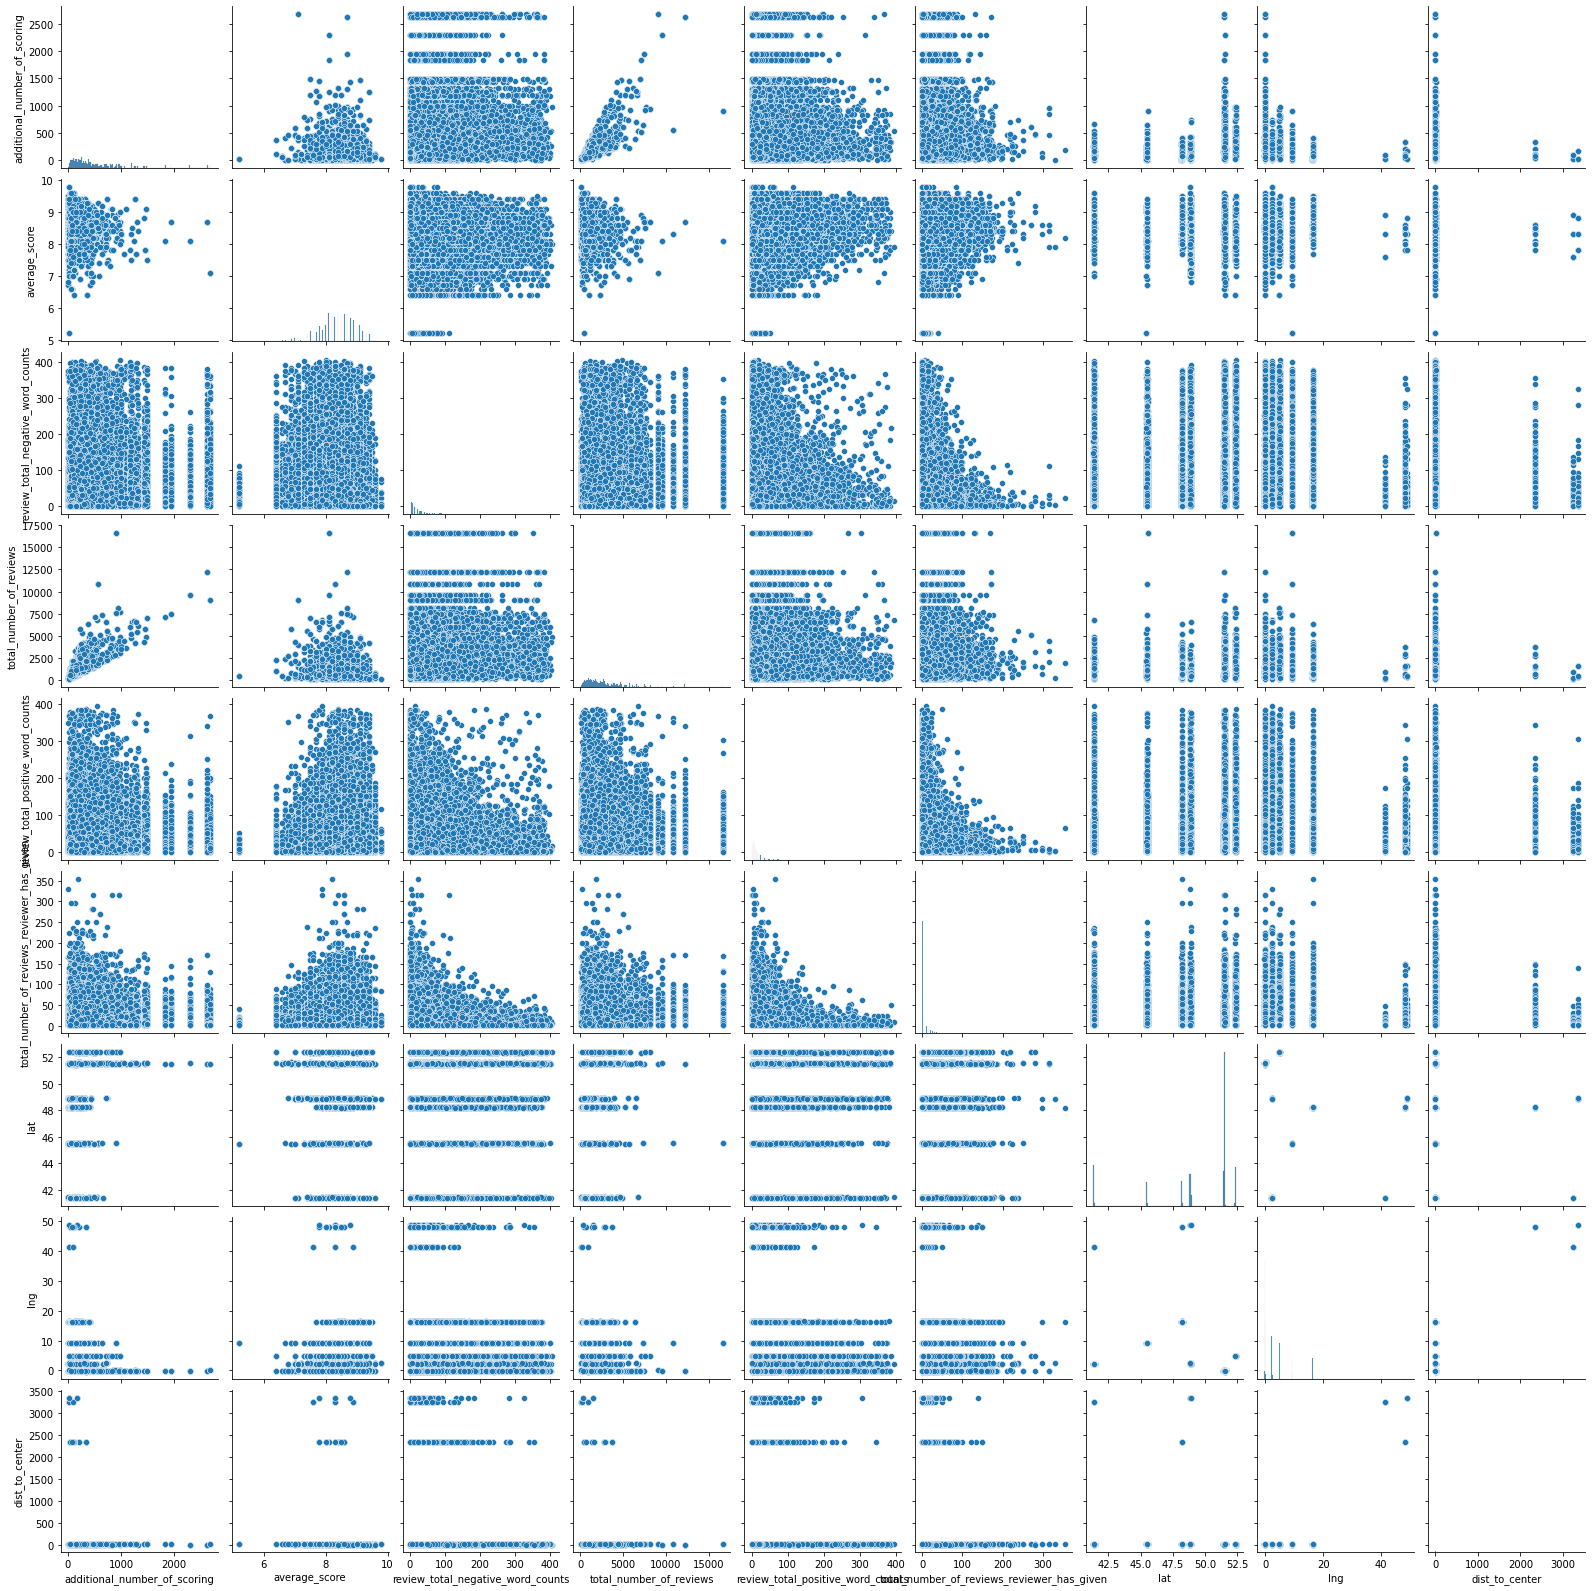

In [352]:
#Визуально оценим распредление количественных признаков и их зависимость друг от друга
sns.pairplot(df_num)

На первый взгляд просается зависимость между признаками:

- "total_number_of_reviews" и "additional_number_of_scoring";
- "review_total_negative_word_counts" и "total_number_of_reviews_reviewer_has_given";
- "review_total_positive_word_counts" и "total_number_of_reviews_reviewer_has_given".

Бросается в глаза и то, что признак "dist_to_center" имеет очень большие выбросы.

Чтобы снова оценить зависимость признаков, уберем аномальные выбросы.

Text(0.5, 0, 'Расстояния отеля до центра города')

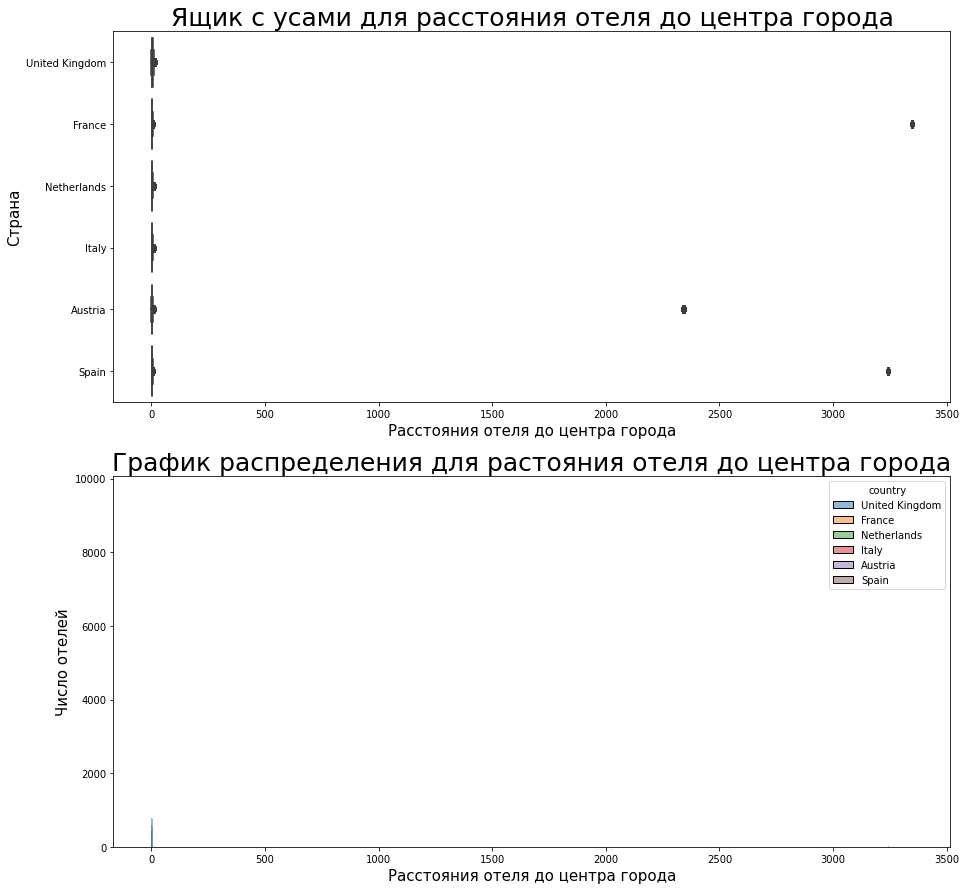

In [353]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
sns.boxplot(
    data=df_num,
    x='dist_to_center',
    y = 'country',
    ax=axes[0]
)
sns.histplot(
    data=df_num,
    x='dist_to_center',
    hue='country',
    ax=axes[1]
)
axes[0].set_title('Ящик с усами для расстояния отеля до центра города', fontsize = 25)
axes[0].set_ylabel('Страна', fontsize = 15)
axes[0].set_xlabel('Расстояния отеля до центра города', fontsize = 15)
axes[1].set_title('График распределения для растояния отеля до центра города', fontsize = 25)
axes[1].set_ylabel('Число отелей', fontsize = 15)
axes[1].set_xlabel('Расстояния отеля до центра города', fontsize = 15)

Оценим отели без аномальных координат

Text(0.5, 0, 'Расстояния отеля до центра города')

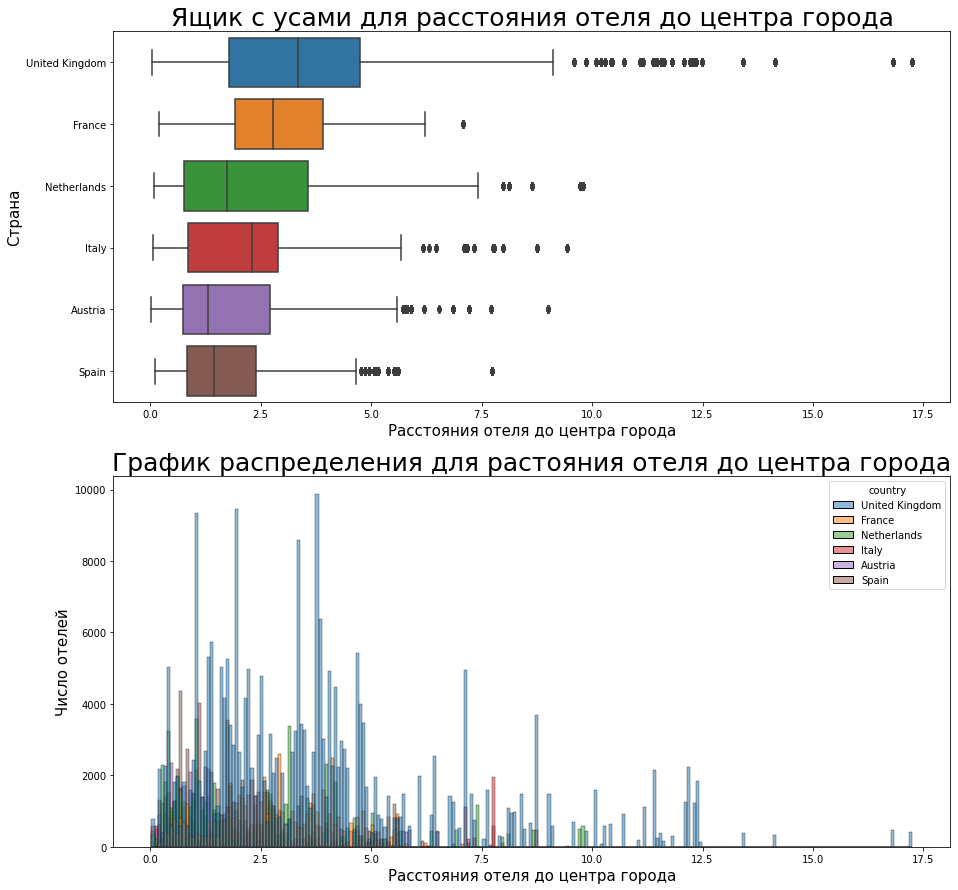

In [354]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
sns.boxplot(
    x= df_num[df_num['dist_to_center']<500]['dist_to_center'],
    y= df_num[df_num['dist_to_center']<500]['country'],
    ax=axes[0]
)
sns.histplot(
    x= df_num[df_num['dist_to_center']<500]['dist_to_center'],
    hue= hotels['country'],
    ax=axes[1]
)
axes[0].set_title('Ящик с усами для расстояния отеля до центра города', fontsize = 25)
axes[0].set_ylabel('Страна', fontsize = 15)
axes[0].set_xlabel('Расстояния отеля до центра города', fontsize = 15)
axes[1].set_title('График распределения для растояния отеля до центра города', fontsize = 25)
axes[1].set_ylabel('Число отелей', fontsize = 15)
axes[1].set_xlabel('Расстояния отеля до центра города', fontsize = 15)

Для стран: "France", "Austria", "Spain" имеются выбросы. Принимая во внимание, что датасет включает в себя отели только определенных город, скорее всего здесь, что-то не так с локацией отеля. Оценим отели, которые имеют аномальное растояние до центра города, а также построим график для отелей без аномального растояния.

In [355]:
outliers_lst = list(df_num[df_num['dist_to_center']>500].index)
df_num[df_num['dist_to_center']>500]['country'].value_counts()

Austria    2679
France      382
Spain       207
Name: country, dtype: int64

Больше всего таких отзывов в Австрии. Оценим отели!


In [356]:
hotels['hotel_name'][outliers_lst].value_counts()

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64

Загуглим эти отели на карте.

Во всех этих отлеях ошибочно опредлена долгота отеля. Изменим ее.

In [357]:
hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City']['lng'] = 16.35337
hotels[hotels['hotel_name'] == 'Hotel City Central']['lng'] = 16.3801
hotels[hotels['hotel_name'] == 'Hotel Atlanta']['lng'] = 16.35582
hotels[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond']['lng'] = 2.30893
hotels[hotels['hotel_name'] == 'Hotel Daniel Vienna']['lng'] = 16.396411
hotels[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor']['lng'] = 16.3600838
hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien']['lng'] = 16.28554
hotels[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna']['lng'] = 16.34124
hotels[hotels['hotel_name'] == 'NH Collection Barcelona Podium']['lng'] = 2.17769
hotels[hotels['hotel_name'] == 'City Hotel Deutschmeister']['lng'] = 16.366614
hotels[hotels['hotel_name'] == 'Hotel Park Villa']['lng'] = 16.3458485
hotels[hotels['hotel_name'] == 'Cordial Theaterhotel Wien']['lng'] = 16.35147
hotels[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre']['lng'] = 2.333124
hotels[hotels['hotel_name'] == 'Roomz Vienna']['lng'] = 16.42064
hotels[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse']['lng'] = 2.32356
hotels[hotels['hotel_name'] == 'Renaissance Barcelona Hotel']['lng'] = 2.1673534
hotels[hotels['hotel_name'] == 'Hotel Advance']['lng'] = 2.162944

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/4216448906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City']['lng'] = 16.35337
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/4216448906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels[hotels['hotel_name'] == 'Hotel City Central']['lng'] = 16.3801
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/4216448906.py:3: SettingWithCopyW

Заменим эти данные в датасете с количественными признаками.

In [358]:
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City'].index)] = 16.35337
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel City Central'].index)] = 16.3801
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel Atlanta'].index)] = 16.35582
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond'].index)] = 2.30893
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel Daniel Vienna'].index)] = 16.396411
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor'].index)] = 16.3600838
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien'].index)] = 16.28554
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna'].index)] = 16.34124
df_num['lng'][list(hotels[hotels['hotel_name'] == 'NH Collection Barcelona Podium'].index)] = 2.17769
df_num['lng'][list(hotels[hotels['hotel_name'] == 'City Hotel Deutschmeister'].index)] = 16.366614
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel Park Villa'].index)] = 16.3458485
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Cordial Theaterhotel Wien'].index)] = 16.35147
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre'].index)] = 2.333124
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Roomz Vienna'].index)] = 16.42064
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse'].index)] = 2.32356
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Renaissance Barcelona Hotel'].index)] = 2.1673534
df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel Advance'].index)] = 2.162944

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1125849799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['lng'][list(hotels[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City'].index)] = 16.35337
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1125849799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['lng'][list(hotels[hotels['hotel_name'] == 'Hotel City Central'].index)] = 16.3801
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1125849799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [359]:
# Пересоздаем признак dist_to_center
# создаем признаки географической широты и долготы для центра столиц в датасете
df_num['lat_city_center'] = df_num['country'].apply(lambda x: lat_dict[x])
df_num['lng_city_center'] = df_num['country'].apply(lambda x: lng_dict[x])
# Определим удаленность отеля от центра, создадим столбец с нулевыми значениями.
position_1_lst = []
for i in list(df_num.index):
    position_1 = (df_num['lat'][i], df_num['lng'][i])
    position_1_lst.append(position_1)
position_2_lst = []
for i in list(df_num.index):
    position_2 = (df_num['lat_city_center'][i], df_num['lng_city_center'][i])
    position_2_lst.append(position_2)
# Для работы с геогрфическими координатами можно использовать библиотеку haversine.
# Установим и импортируем ее.
from haversine import haversine, Unit
dist_to_center = []
for i in list(range(len(position_1_lst))):
    distance = haversine(position_1_lst[i], position_2_lst[i])
    dist_to_center.append(distance)
df_num['dist_to_center'] = pd.DataFrame(dist_to_center, columns=['dist_to_center'])
# удаляем лишьние признаки, которые использовались для расчета признака "dist_to_center"
df_num = df_num.drop(['lat_city_center', 'lng_city_center'], axis=1)

Еще раз оценим исходные данные по признаку "dist_to_center"

Text(0.5, 0, 'Расстояния отеля до центра города')

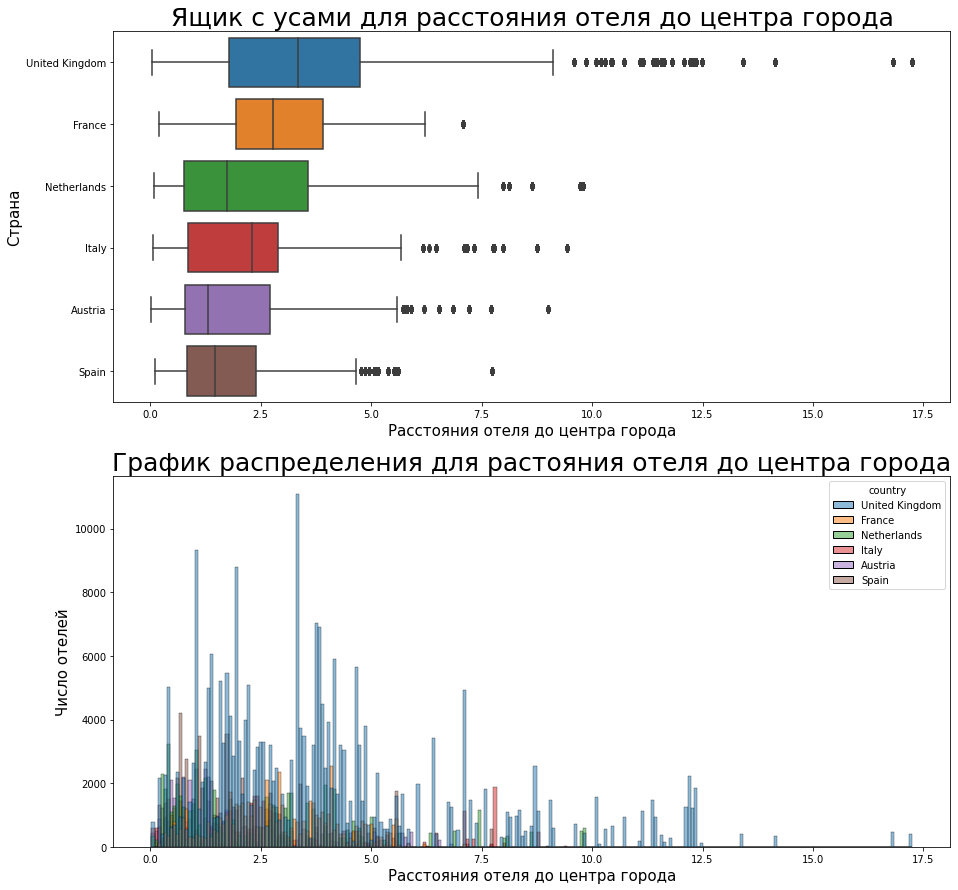

In [360]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
sns.boxplot(
    data=df_num,
    x='dist_to_center',
    y = 'country',
    ax=axes[0]
)
sns.histplot(
    data=df_num,
    x='dist_to_center',
    hue='country',
    ax=axes[1]
)
axes[0].set_title('Ящик с усами для расстояния отеля до центра города', fontsize = 25)
axes[0].set_ylabel('Страна', fontsize = 15)
axes[0].set_xlabel('Расстояния отеля до центра города', fontsize = 15)
axes[1].set_title('График распределения для растояния отеля до центра города', fontsize = 25)
axes[1].set_ylabel('Число отелей', fontsize = 15)
axes[1].set_xlabel('Расстояния отеля до центра города', fontsize = 15)

In [361]:
# удалим признаки "lat" и "lng"
df_num = df_num.drop(['lat', 'lng'], axis=1)

Снова оценим зависимость количественных признаков

In [362]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 8 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   country                                     515431 non-null  object 
 7   dist_to_center                              515431 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 31.5+ MB


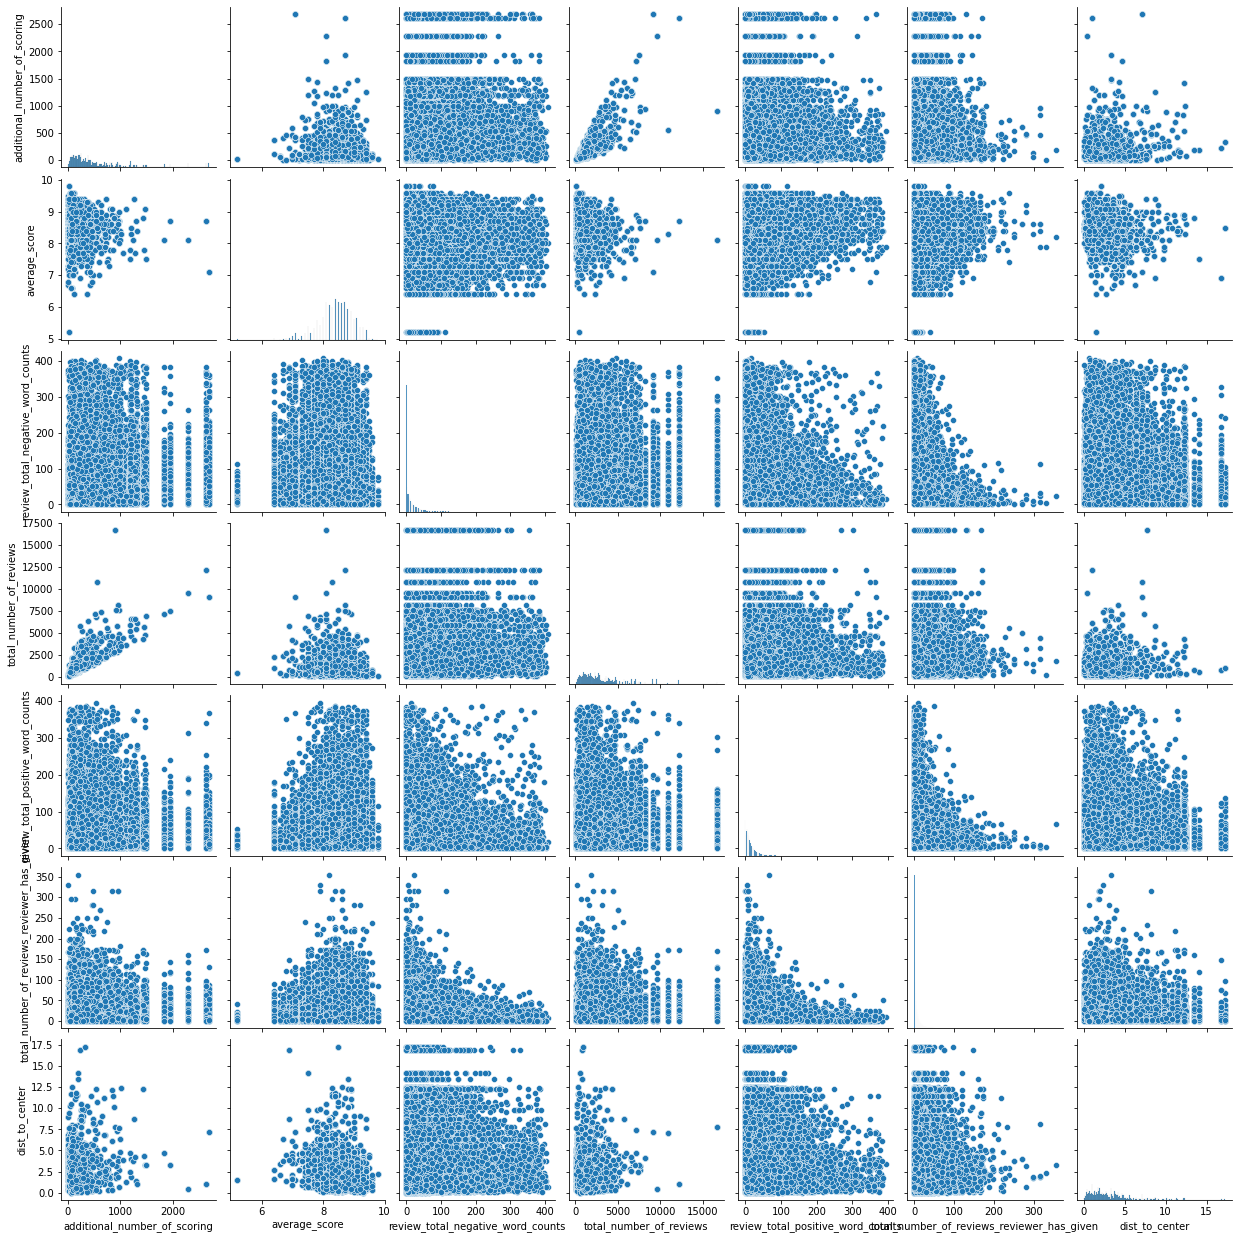

In [363]:
sns.pairplot(df_num)

Остается зависимость между признаками:

- "total_number_of_reviews" и "additional_number_of_scoring";
- "review_total_negative_word_counts" и "total_number_of_reviews_reviewer_has_given";
- "review_total_positive_word_counts" и "total_number_of_reviews_reviewer_has_given".

Добавилась зависимость между признаками:

- "additional_number_of_scoring" и "dist_to_center";
- "average_score" и "dist_to_center";
- "review_total_positive_word_counts" и "dist_to_center".

Будем использовать эту информацию для дальнейшей обработки.

Напишем функции:

1) График для визуализации распредления признака;
2) Оценки нормальности распределения;
3) Оценка наличия выбросов по методу Тьюки;
4) Оценка корреляционной связи и ее значимости.

In [364]:
# создаем функцию для визуализации распредления признака
def vis_distrib(df, feature_1, feature_2):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20,15))
    sns.boxplot(
        data=df,
        x=feature_1,
        y=feature_2,
        ax=axes[0]
    )
    sns.histplot(
        data=df,
        x=feature_1,
        kde=True,
        ax=axes[1]
    )
    axes[0].set_title(f'Ящик с усами признака {feature_1}', fontsize = 25)
    axes[0].set_ylabel(feature_2, fontsize = 15)
    axes[0].set_xlabel(feature_1, fontsize = 15)
    axes[1].set_title(f'График распредления признака {feature_1}', fontsize = 25)
    axes[1].set_ylabel('Число упоминаний события', fontsize = 15)
    axes[1].set_xlabel(feature_1, fontsize = 15)
# создаем функцию для оценки нормальности распределения
def check_normality(df, feature):
    from scipy.stats import normaltest
    H0 = 'Данные имеют нормальное распредление'
    H1 = 'Данные имеют отличное от нормального распределение'
    alpha = 0.05
    _, p = normaltest(df[feature])
    if p > alpha:
        print(H0,f'для признака {feature}.')
    else:
        print(H1, f'для признака {feature}.')
# создаем функцию для оценки выбросов
def check_outliers_iqr(df, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale == True:
        x = np.log(df[feature])
    else:
        x = df[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) | (x < upper_bound)]
    return outliers, cleaned
# создаем функцию для оценки корреляционной связи и ее значимости
def check_correlation(df, feature_1, feature_2):
    from scipy.stats import spearmanr
    from scipy.stats import pearsonr
    from scipy.stats import normaltest
    H0 = 'Данные имеют нормальное распредление'
    H1 = 'Данные имеют отличное от нормального распределение'
    alpha = 0.05
    _, p = normaltest(df[feature_1])
    if p > alpha:
        corr, p = pearsonr([df[feature_1], df[feature_2]])
        print(f'Корреляционная связь признака {feature_1} с признаком {feature_2} равна {corr}, значимость - {p}.')
    else:
        corr, p = spearmanr([df[feature_1], df[feature_2]])
        print(f'Корреляционная связь признака {feature_1} с признаком {feature_2} равна {corr}, значимость - {p}.')

In [365]:
# Опредляем количественные признаки
num_cols = [
    'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'dist_to_center'
]

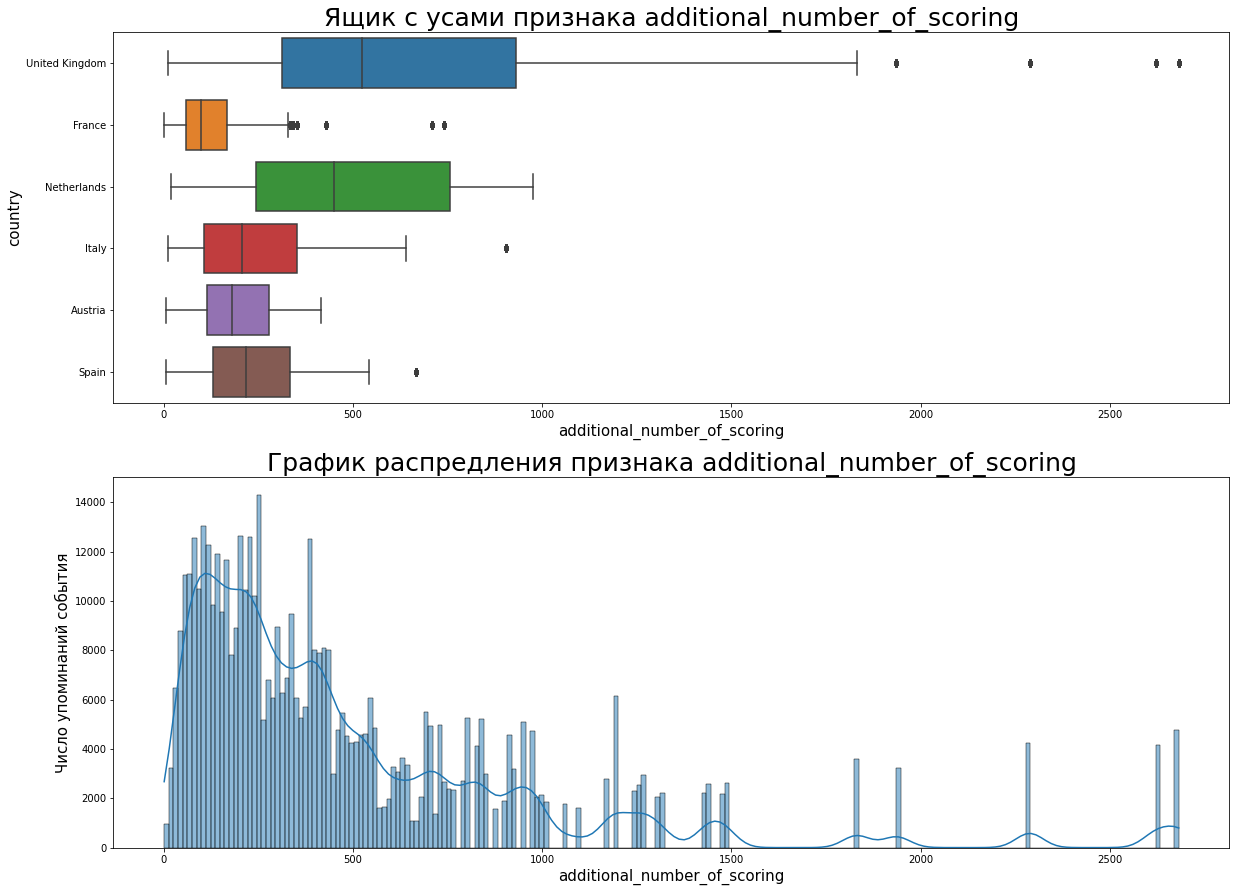

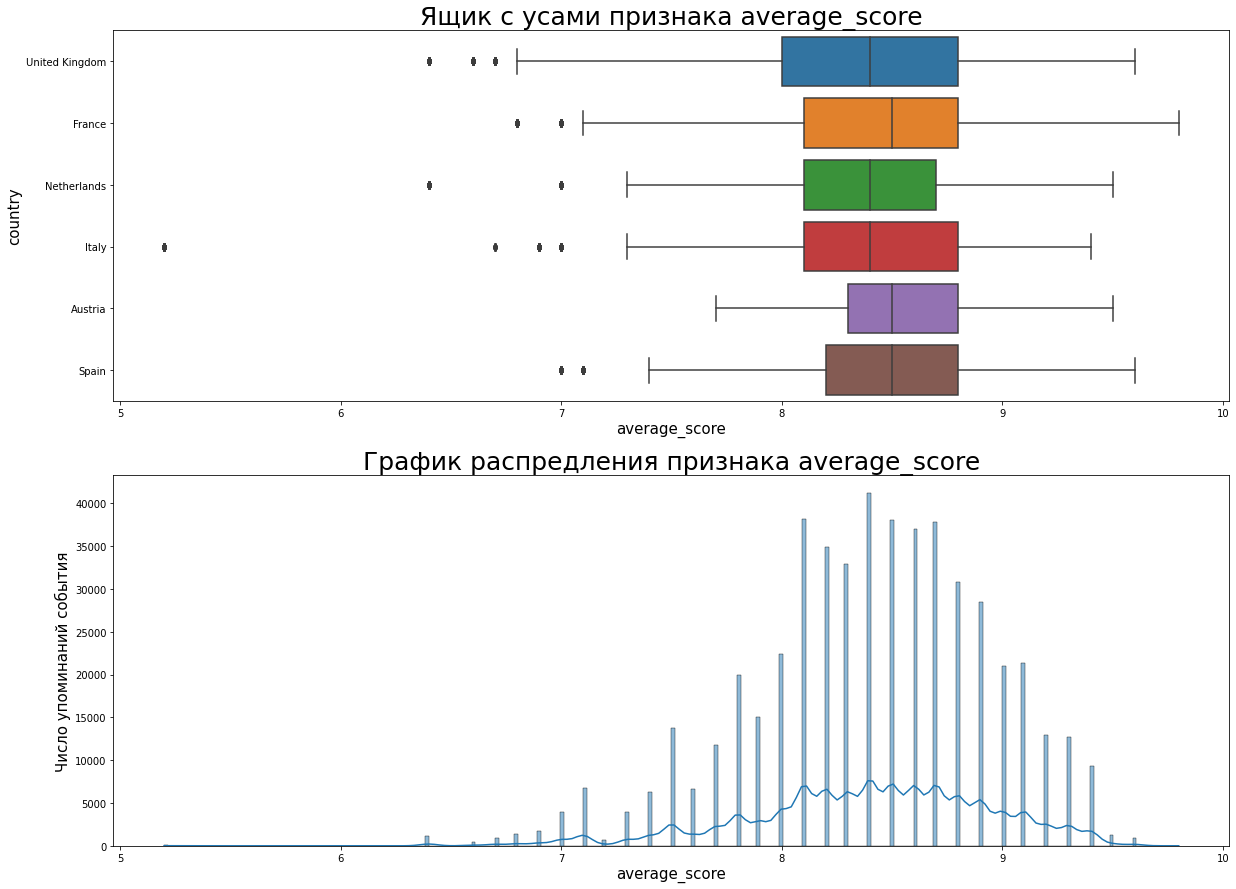

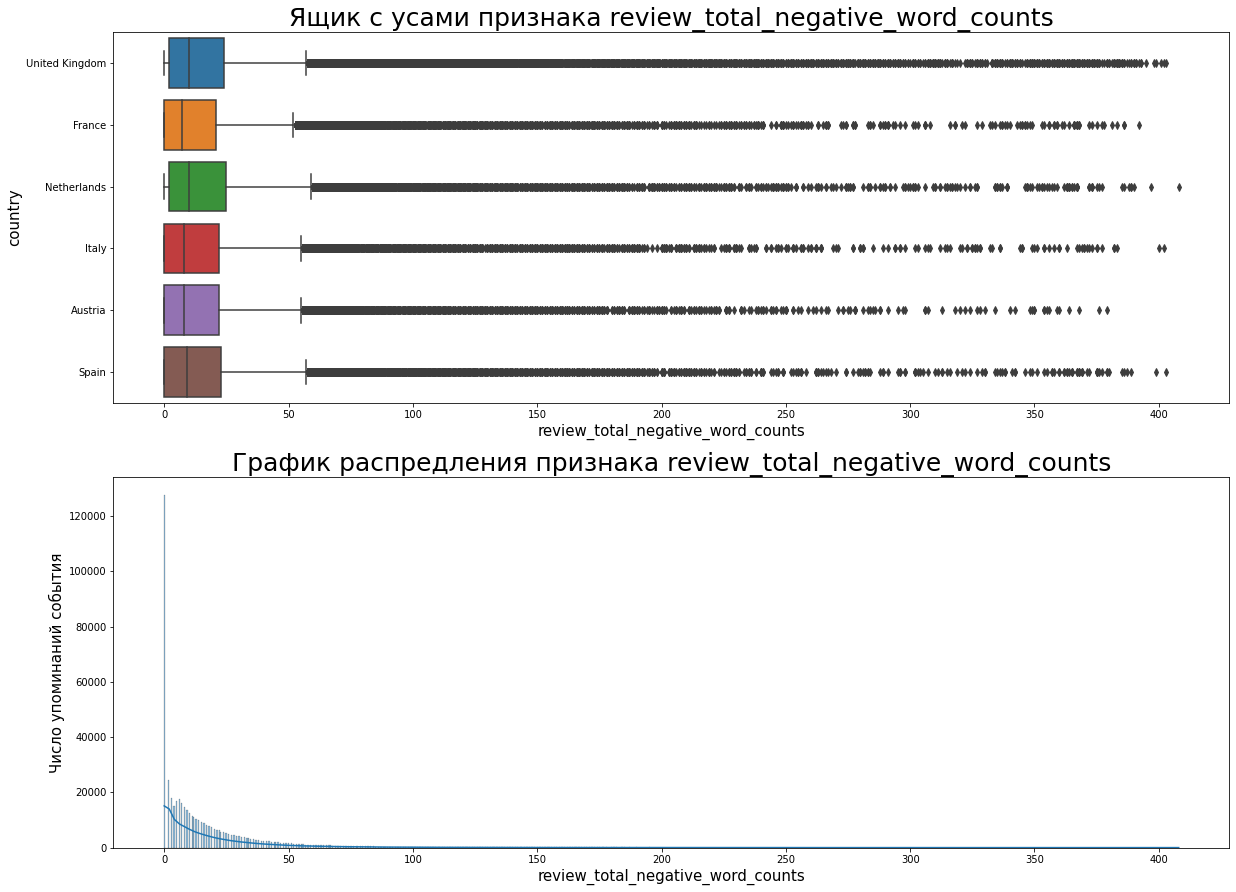

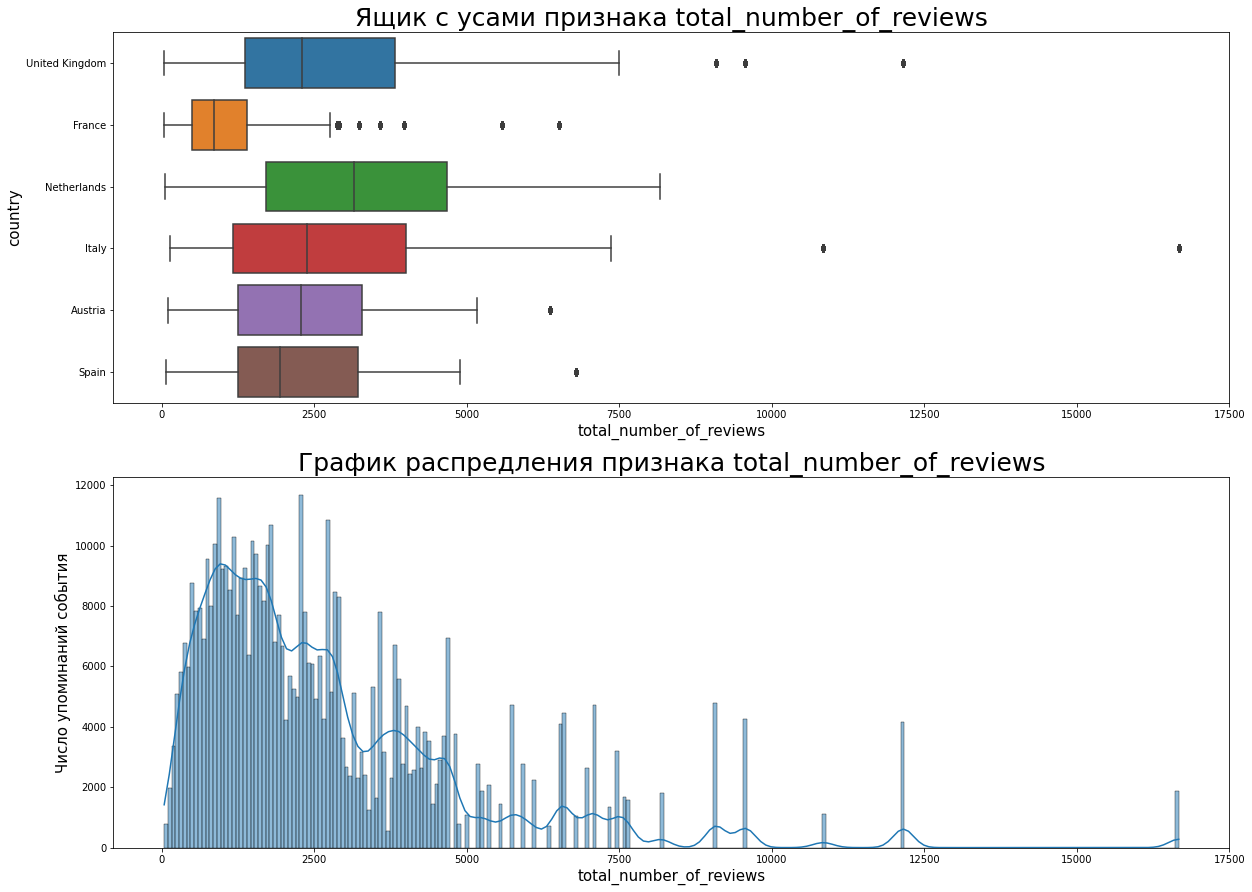

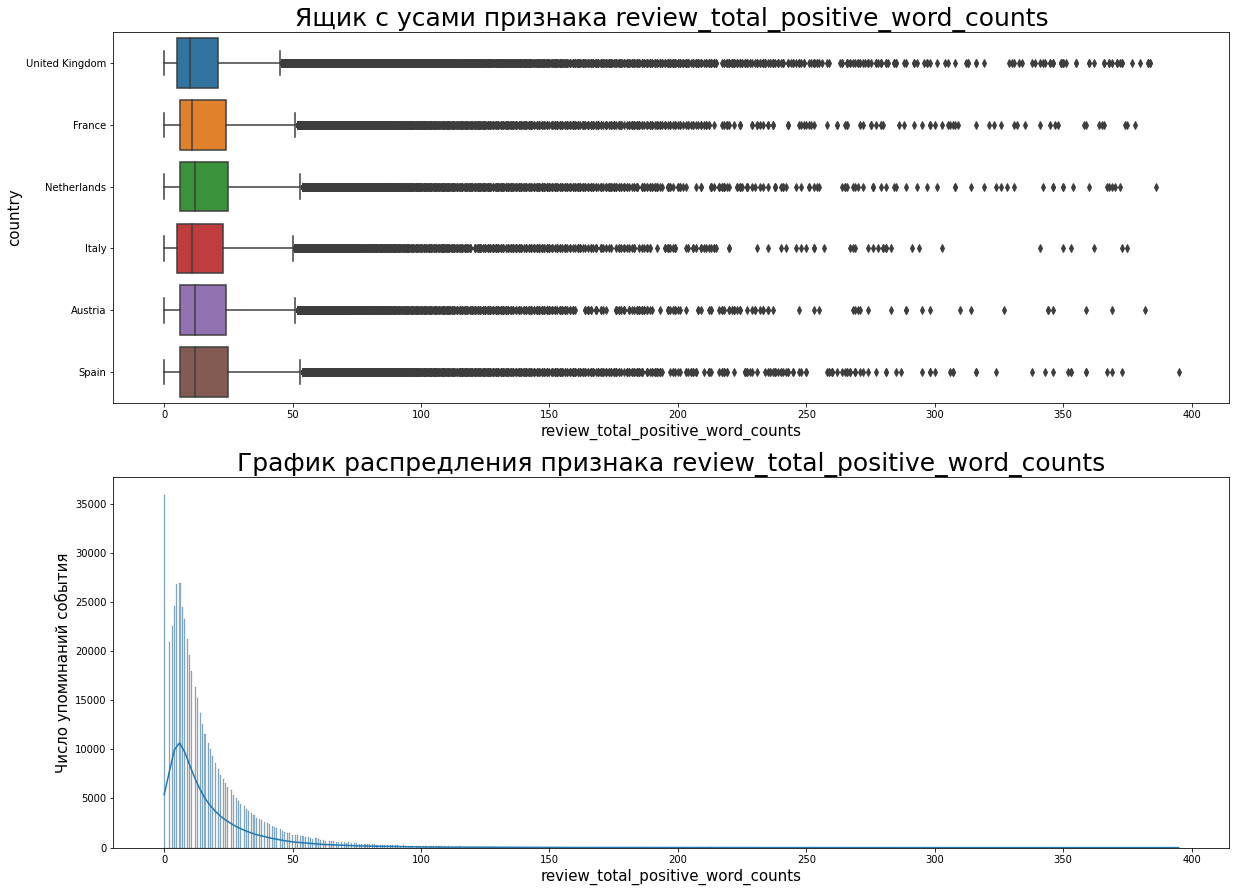

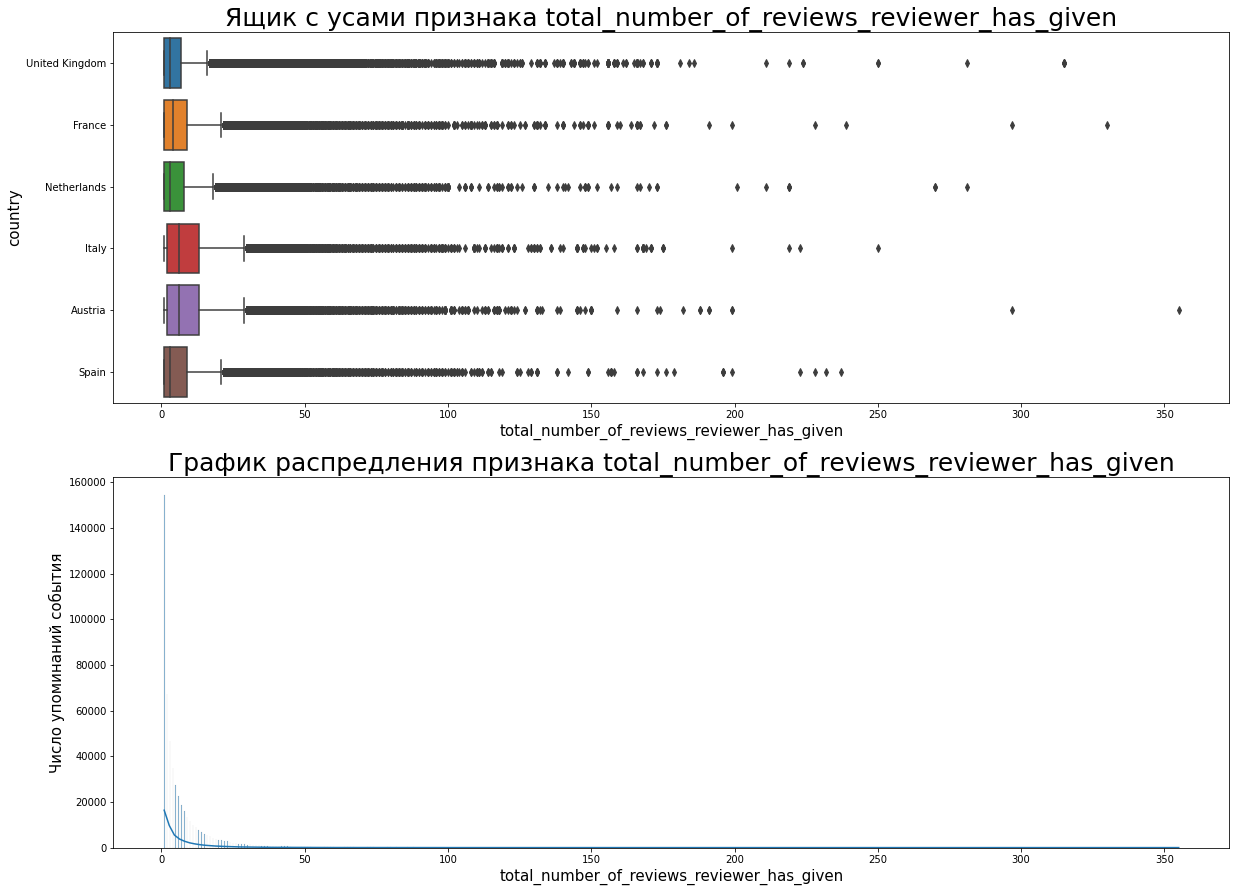

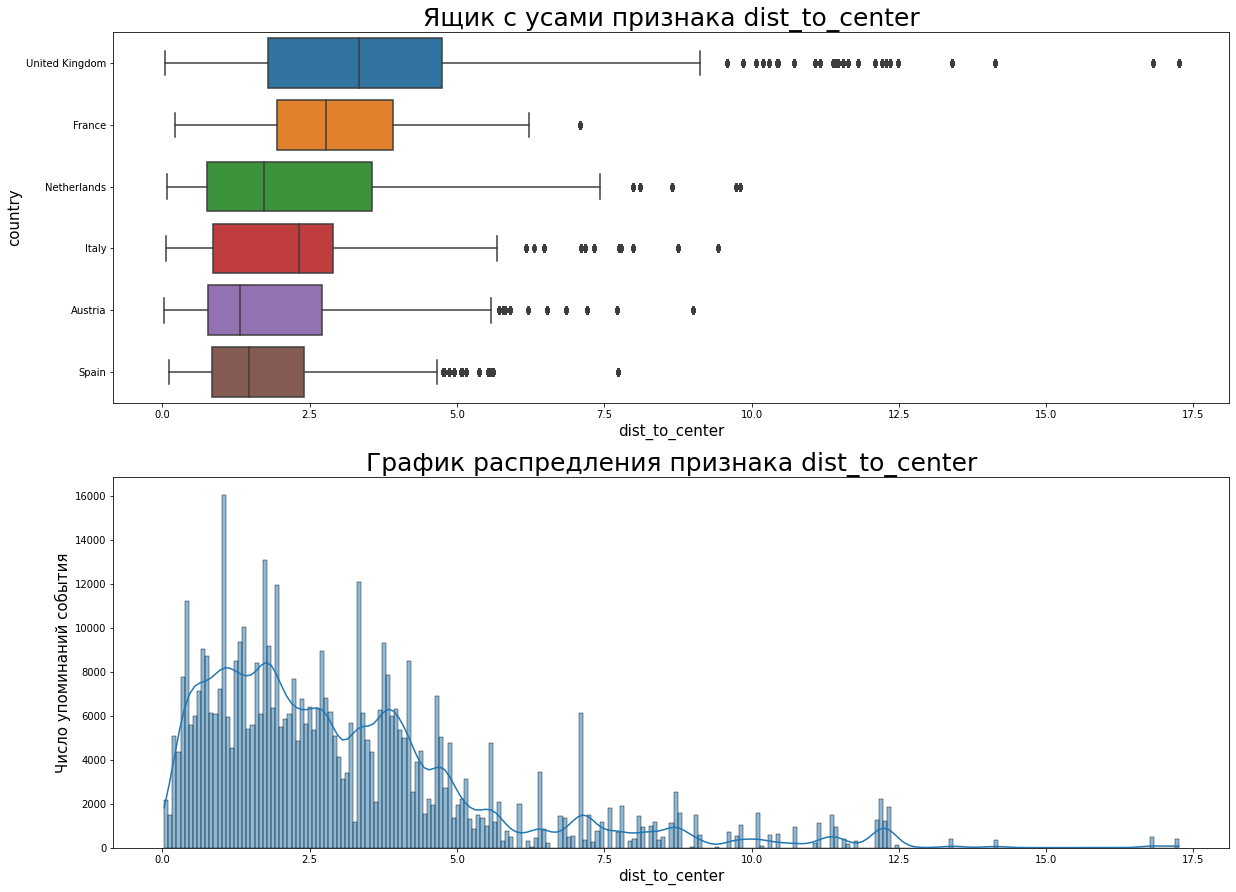

In [366]:
# Визуализируем распределение
for col in num_cols:
    vis_distrib(df=df_num, feature_1=col, feature_2='country')

In [367]:
# Пределяем нормальность распределения
for col in num_cols:
    check_normality(df=df_num, feature=col)

Данные имеют отличное от нормального распределение для признака additional_number_of_scoring.
Данные имеют отличное от нормального распределение для признака average_score.
Данные имеют отличное от нормального распределение для признака review_total_negative_word_counts.
Данные имеют отличное от нормального распределение для признака total_number_of_reviews.
Данные имеют отличное от нормального распределение для признака review_total_positive_word_counts.
Данные имеют отличное от нормального распределение для признака total_number_of_reviews_reviewer_has_given.
Данные имеют отличное от нормального распределение для признака dist_to_center.


In [368]:
for col in num_cols:
    outliers, cleaned = check_outliers_iqr(df=df_num, feature=col)
    print(f'Признак {col} имеет {outliers.shape[0]} число выбросов по методу Тьюки.\n')

Признак additional_number_of_scoring имеет 29579 число выбросов по методу Тьюки.

Признак average_score имеет 9556 число выбросов по методу Тьюки.

Признак review_total_negative_word_counts имеет 39137 число выбросов по методу Тьюки.

Признак total_number_of_reviews имеет 25826 число выбросов по методу Тьюки.

Признак review_total_positive_word_counts имеет 36313 число выбросов по методу Тьюки.

Признак total_number_of_reviews_reviewer_has_given имеет 47747 число выбросов по методу Тьюки.

Признак dist_to_center имеет 28259 число выбросов по методу Тьюки.



Работаем с признаками:

- "review_total_negative_word_counts" — общее количество слов в отрицательном отзыв;

и

- "review_total_positive_word_counts" — общее количество слов в положительном отзыве.

In [369]:
df_num[['review_total_positive_word_counts', 'review_total_negative_word_counts']].describe()

review_total_positive_word_counts  review_total_negative_word_counts
count                      515431.000000                      515431.000000
mean                           17.777342                          18.539760
std                            21.803204                          29.690973
min                             0.000000                           0.000000
25%                             5.000000                           2.000000
50%                            11.000000                           9.000000
75%                            22.000000                          23.000000
max                           395.000000                         408.000000

In [370]:
# Создадим признак пропорции между положительным и отрицательным число слов в отзывах.
# Если соотношение больше 0.5, то посетитель удовлетворен. Если менее 0.5, то поситетель неудовлетворен.
df_num['pos_neg_word_proportion'] = round(df_num.review_total_positive_word_counts/(df_num.review_total_positive_word_counts+df_num.review_total_negative_word_counts), 2)
# Так как есть нулевое число слов в положительных и отрицательных отзывах, заменим NaN на 0
df_num['pos_neg_word_proportion'] = df_num['pos_neg_word_proportion'].fillna(0)

In [371]:
# Проверим наличие NaN
df_num[df_num['pos_neg_word_proportion'].isna() == True][['review_total_negative_word_counts', 'review_total_positive_word_counts', 'pos_neg_word_proportion']].head()

Empty DataFrame
Columns: [review_total_negative_word_counts, review_total_positive_word_counts, pos_neg_word_proportion]
Index: []

In [372]:
df_num['pos_neg_word_proportion'].value_counts().head()

1.00    127689
0.00     35924
0.50     15932
0.33      8878
0.38      7383
Name: pos_neg_word_proportion, dtype: int64

Отлично NaN нет.

Данные имеют отличное от нормального распределение для признака pos_neg_word_proportion.
Признак dist_to_center имеет 0 число выбросов по методу Тьюки.


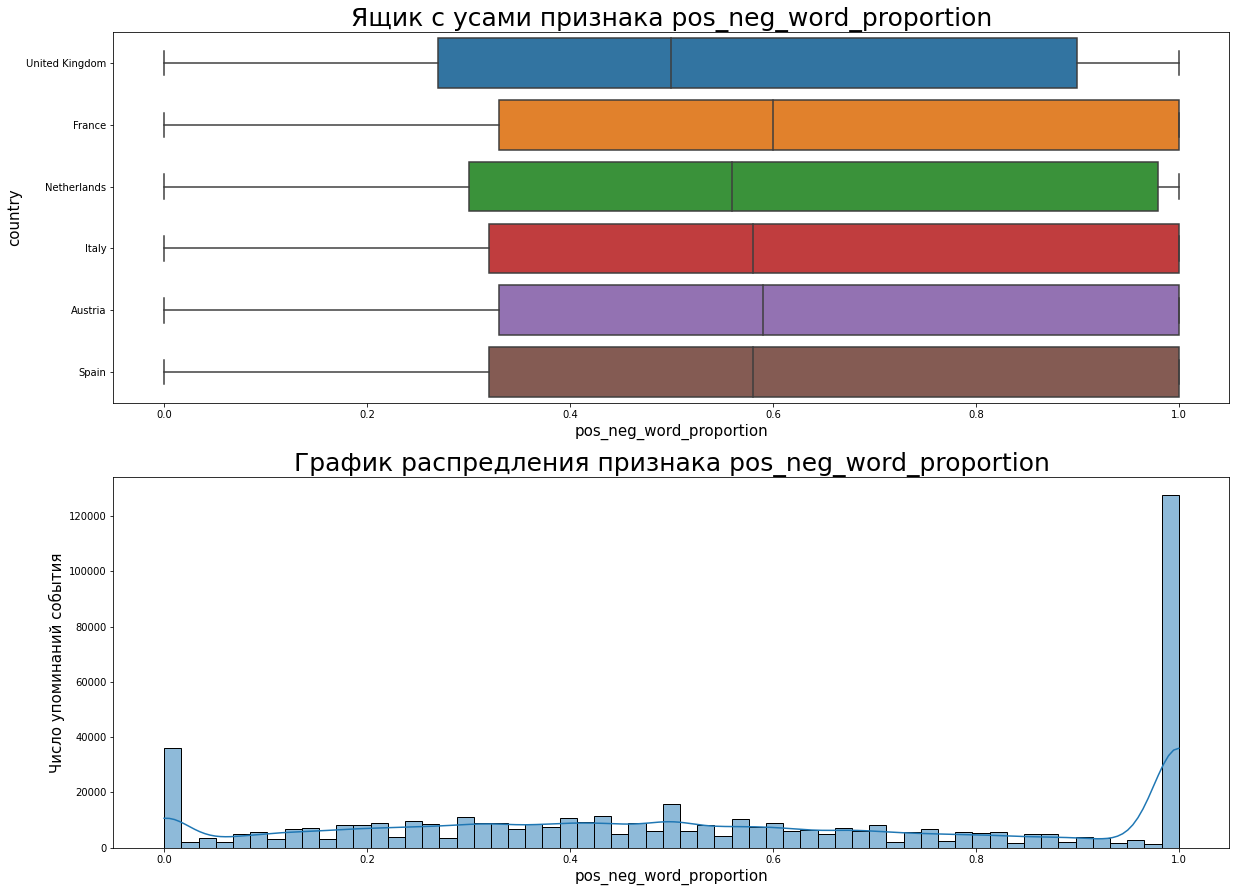

In [373]:
# Оцениваем новый признак "pos_neg_word_proportion"
vis_distrib(df=df_num, feature_1='pos_neg_word_proportion', feature_2='country')
check_normality(df=df_num, feature='pos_neg_word_proportion')
outliers, cleaned = check_outliers_iqr(df=df_num, feature='pos_neg_word_proportion')
print(f'Признак {col} имеет {outliers.shape[0]} число выбросов по методу Тьюки.')

Отлично. Проработаем оставшийся признак "total_number_of_reviews_reviewer_has_given", который имеет большое число выбросов.

In [374]:
# Оценим зависимость суммарное число слов в положительном и отрицательном отзывах 
# относительно всего числа отзывов, которые оставлял пользователь
# Создаем признак суммарного числа слов в отзыве
df_num['review_total_word_counts'] = df_num['review_total_positive_word_counts'] + df_num['review_total_negative_word_counts']

Text(0, 0.5, 'Сумарное число отзывов от пользователя на сервисе')

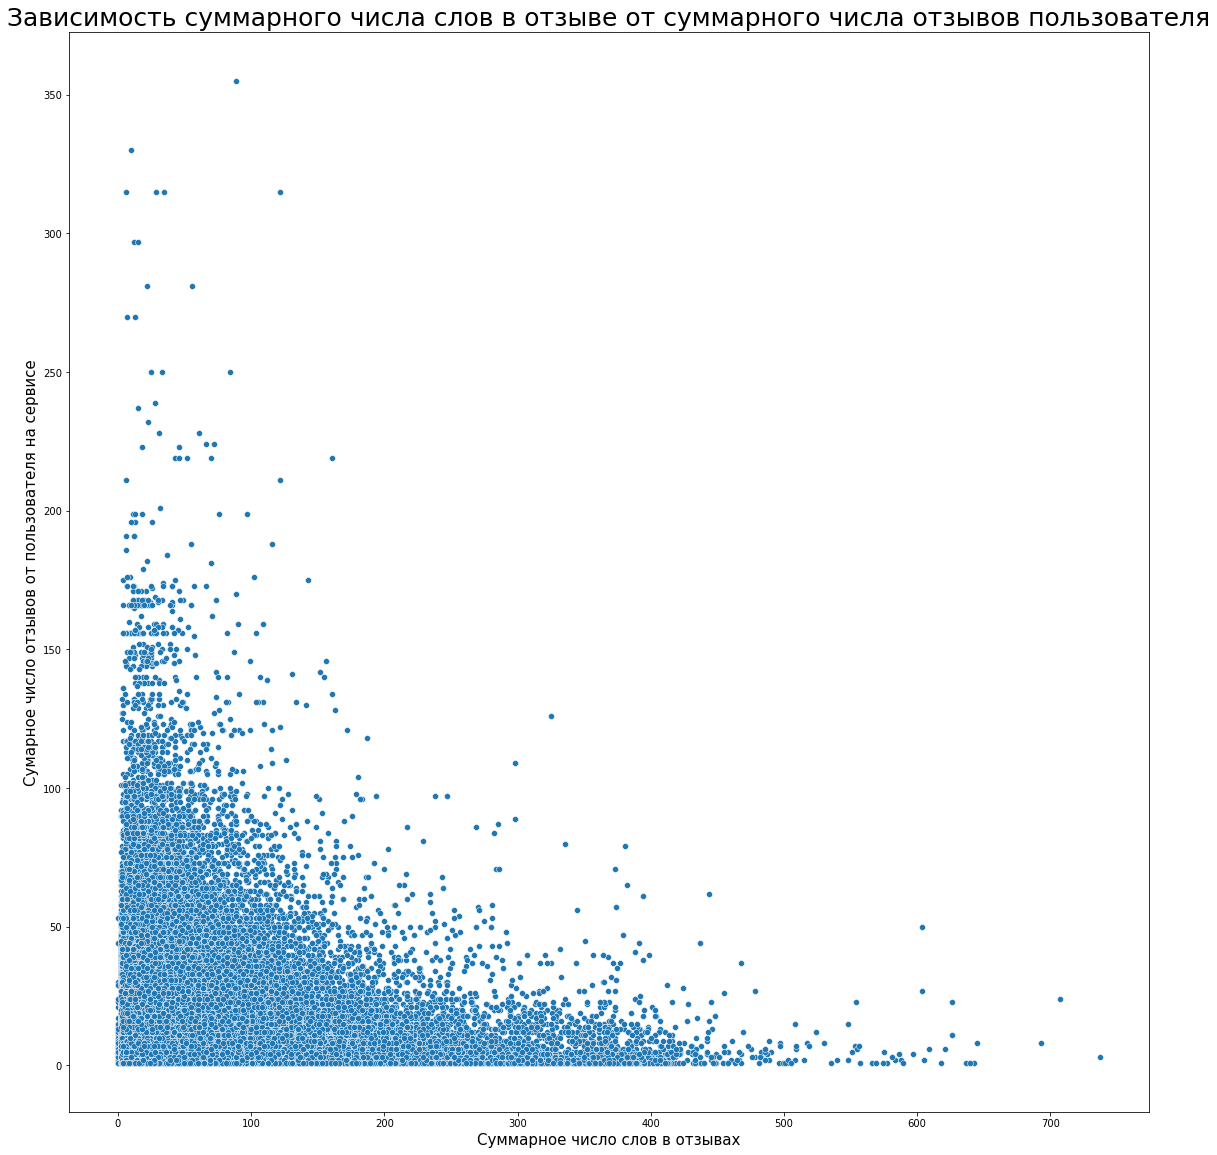

In [375]:
# оцениваем зависимость с помощью scatterplot
fig = plt.figure(figsize=(15,15))
axes = fig.add_axes([0,0,1,1])
sns.scatterplot(
    y=df_num['total_number_of_reviews_reviewer_has_given'],
    x=df_num['review_total_word_counts']
)
axes.set_title('Зависимость суммарного числа слов в отзыве от суммарного числа отзывов пользователя', fontsize=25)
axes.set_xlabel('Суммарное число слов в отзывах', fontsize=15)
axes.set_ylabel('Сумарное число отзывов от пользователя на сервисе', fontsize=15)

Из графика видно, что максимальная плотность пользователей назодится в пределах координат (250, 150).

Пришло время объеденить датасеты и оценить влияние признаков в тренировочном датасете на предсказываемый параметр, а также удалить признаки, которые имеют мультиколлинеарность.

In [376]:
print(df_num.shape)
print(df_object.shape)
print(df_num.shape[0] == df_object.shape[0])

(515431, 10)
(515431, 164)
True


Отлично датасеты равны, объединяем!

In [377]:
hotels = pd.concat([df_num, df_object], axis=1)
hotels.shape

(515431, 174)

In [378]:
display(hotels[hotels.isna() == True].describe())
print(list(hotels.columns))


additional_number_of_scoring  average_score  \
count                           0.0            0.0   
mean                            NaN            NaN   
std                             NaN            NaN   
min                             NaN            NaN   
25%                             NaN            NaN   
50%                             NaN            NaN   
75%                             NaN            NaN   
max                             NaN            NaN   

       review_total_negative_word_counts  total_number_of_reviews  \
count                                0.0                      0.0   
mean                                 NaN                      NaN   
std                                  NaN                      NaN   
min                                  NaN                      NaN   
25%                                  NaN                      NaN   
50%                                  NaN                      NaN   
75%                                  NaN                      NaN   
max                                  NaN                      NaN   

       review_total_positive_word_counts  \
count                                0.0   
mean                                 NaN   
std                                  NaN   
min                                  NaN   
25%                                  NaN   
50%                                  NaN   
75%                                  NaN   
max                                  NaN   

       total_number_of_reviews_reviewer_has_given  dist_to_center  \
count                                         0.0             0.0   
mean                                          NaN             NaN   
std                                           NaN             NaN   
min                                           NaN             NaN   
25%                                           NaN             NaN   
50%                                           NaN             NaN   
75%                                           NaN             NaN   
max                                           NaN             NaN   

       pos_neg_word_proportion  review_total_word_counts  days_since_review  \
count                      0.0                       0.0                0.0   
mean                       NaN                       NaN                NaN   
std                        NaN                       NaN                NaN   
min                        NaN                       NaN                NaN   
25%                        NaN                       NaN                NaN   
50%                        NaN                       NaN                NaN   
75%                        NaN                       NaN                NaN   
max                        NaN                       NaN                NaN   

       review_year  review_month  review_day  review_day_of_week  \
count          0.0           0.0         0.0                 0.0   
mean           NaN           NaN         NaN                 NaN   
std            NaN           NaN         NaN                 NaN   
min            NaN           NaN         NaN                 NaN   
25%            NaN           NaN         NaN                 NaN   
50%            NaN           NaN         NaN                 NaN   
75%            NaN           NaN         NaN                 NaN   
max            NaN           NaN         NaN                 NaN   

       hotel_United Kingdom  hotel_France  hotel_Netherlands  hotel_Italy  \
count                   0.0           0.0                0.0          0.0   
mean                    NaN           NaN                NaN          NaN   
std                     NaN           NaN                NaN          NaN   
min                     NaN           NaN                NaN          NaN   
25%                     NaN           NaN                NaN          NaN   
50%                     NaN           NaN                NaN          NaN   
75%            

['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'country', 'dist_to_center', 'pos_neg_word_proportion', 'review_total_word_counts', 'days_since_review', 'country', 'review_year', 'review_month', 'review_day', 'review_day_of_week', 'hotel_United Kingdom', 'hotel_France', 'hotel_Netherlands', 'hotel_Italy', 'hotel_Austria', 'hotel_Spain', 'reviewer_nationality United Kingdom ', 'reviewer_nationality other', 'reviewer_nationality France ', 'reviewer_nationality Switzerland ', 'reviewer_nationality United Arab Emirates ', 'reviewer_nationality United States of America ', 'reviewer_nationality Netherlands ', 'reviewer_nationality Italy ', 'reviewer_nationality Ireland ', 'reviewer_nationality Canada ', 'reviewer_nationality Germany ', 'reviewer_nationality Australia ', 'reviewer_nationality Israel ', 'reviewer_nationality Turkey ', 'reviewer_na

In [379]:
# так как признаки могут повторяться, то удалим повторы
columns_dict = {}
for col in list(hotels.columns):
    if col not in columns_dict:
        columns_dict[col]=1
    else:
        columns_dict[col]+=1
sorted(columns_dict.items(), key=lambda x: x[1])[-1:]

[('country', 2)]

Повторяется признак 'country'. Удалим его, так как он был перекодирован бинарно.

In [380]:
hotels = hotels.drop('country', axis=1)
# проверяем наличие данного признака
columns_dict = {}
for col in list(hotels.columns):
    if col not in columns_dict:
        columns_dict[col]=1
    else:
        columns_dict[col]+=1
sorted(columns_dict.items(), key=lambda x: x[1])[-1:]

[('neg_markwords_water', 1)]

In [381]:
# Проведем оценку нормальности всего датасета
for col in list(hotels.columns):
    check_normality(df=hotels, feature=col)

Данные имеют отличное от нормального распределение для признака additional_number_of_scoring.
Данные имеют отличное от нормального распределение для признака average_score.
Данные имеют отличное от нормального распределение для признака review_total_negative_word_counts.
Данные имеют отличное от нормального распределение для признака total_number_of_reviews.
Данные имеют отличное от нормального распределение для признака review_total_positive_word_counts.
Данные имеют отличное от нормального распределение для признака total_number_of_reviews_reviewer_has_given.
Данные имеют отличное от нормального распределение для признака dist_to_center.
Данные имеют отличное от нормального распределение для признака pos_neg_word_proportion.
Данные имеют отличное от нормального распределение для признака review_total_word_counts.
Данные имеют отличное от нормального распределение для признака days_since_review.
Данные имеют отличное от нормального распределение для признака review_year.
Данные имеют 

In [382]:
# Добавляем признак разделения на тренировочный и тестовый датасет
hotels = pd.concat([hotels, train_test], axis=1)
# Разделяем датасет на тренировочный и тестовый
hotels_train = hotels[hotels['train_test'] == 1]
hotels_test = hotels[hotels['train_test'] == 0]

In [383]:
# Добавляем прогностический признак к тренировочному датасету
hotels_train = pd.concat([hotels_train, predict_sign], axis=1)

<Axes:>

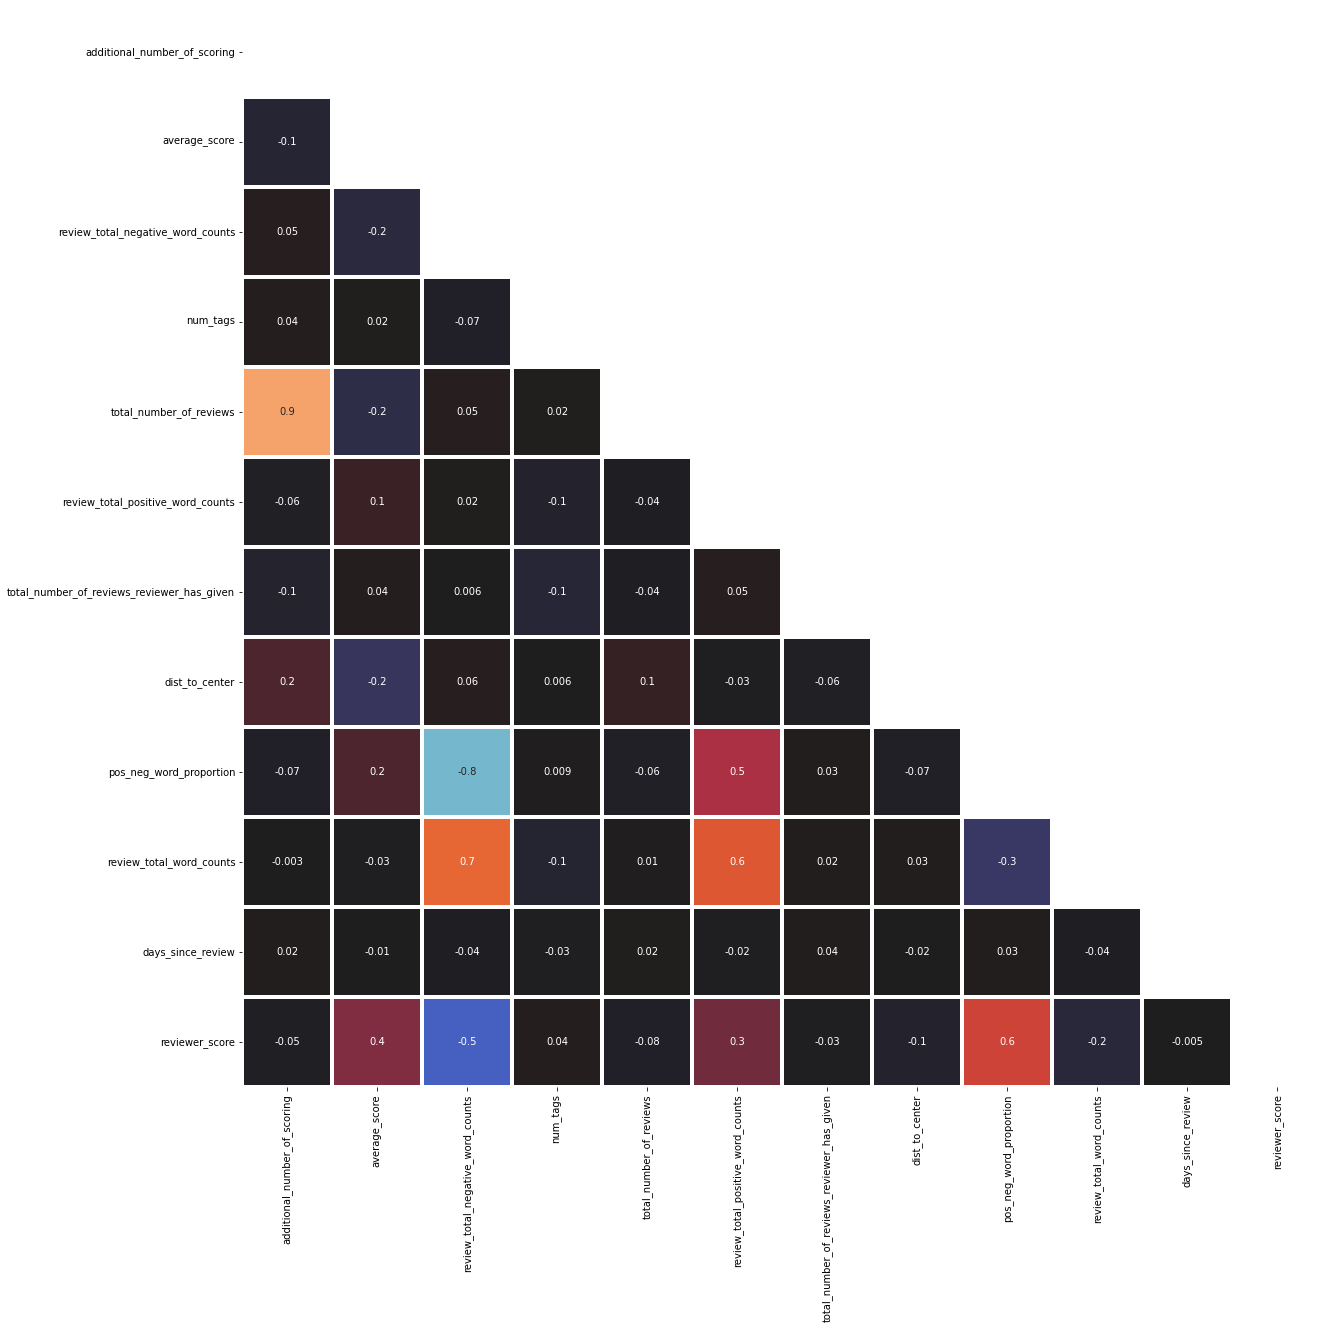

In [384]:
# Оценим тепловую карту корреляционной матрицы
matrix = np.triu(
    hotels_train[[
        'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'num_tags',
        'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
        'dist_to_center', 'pos_neg_word_proportion', 'review_total_word_counts', 'days_since_review', 'reviewer_score'
    ]].corr(method='spearman')
)
fig = plt.figure(figsize=(15,15))
axes = fig.add_axes([0,0,1,1])
sns.heatmap(
    hotels_train[[
        'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'num_tags',
        'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
        'dist_to_center', 'pos_neg_word_proportion', 'review_total_word_counts', 'days_since_review', 'reviewer_score'
    ]].corr(method='spearman'),
    annot=True,
    fmt='.1g',
    vmin = -1,
    vmax = 1,
    center = 0,
    linewidths=4,
    linecolor='white',
    cbar=False,
    mask=matrix
)


Видно, что на признак "reviewer_score" влияют признаки:

- 'average_score';
- 'review_total_negative_word_counts';
- 'review_total_positive_word_counts';
- 'dist_to_center';
- 'pos_neg_word_proportion';
- 'review_total_word_counts'.

Признаки 'review_total_positive_word_counts' и 'pos_neg_word_proportion' могут обладать мультиколлинеарностью, следовательно произ удалим тот, который обладает меньшей корреляционной связью.

In [385]:
hotels_train = hotels_train.drop('review_total_positive_word_counts', axis=1)
hotels_test = hotels_test.drop('review_total_positive_word_counts', axis=1)

Также имеются признаки "review_total_word_counts" и "review_total_negative_word_counts", которые могут взаимовлиять друг на друга. Удалим тот, который обладает меньшей корреляционной связью.

In [386]:
hotels_train = hotels_train.drop('review_total_word_counts', axis=1)
hotels_test = hotels_test.drop('review_total_word_counts', axis=1)

Признаки 'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 
        'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'num_tags',
        'dist_to_center', 'days_since_review', 'reviewer_score' необходимо масштабировать.

Принимая во внимание отсутствие нормальности распредления, произведем масштабирование с помощью RobusrScale и оценим влияние данных признаков.

In [387]:
data = hotels_train[[
        'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 
        'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'num_tags',
        'dist_to_center', 'days_since_review', 'reviewer_score']]

from sklearn import preprocessing
from scipy.stats import spearmanr
for col in list(data.columns):
        data_1 = data
        # удаляем выбросы
        outliers, cleaned = check_outliers_iqr(data, col)
        data_1 = data_1.drop(labels=list(outliers.index), axis=0)

        rb_scaler = preprocessing.RobustScaler()
        sign = rb_scaler.fit_transform(pd.DataFrame(data_1[col]))
        data_1[col] = pd.DataFrame(sign, columns=[col])
        rs = rb_scaler.fit_transform(pd.DataFrame(data_1['reviewer_score']))
        data_1['reviewer_score'] = pd.DataFrame(rs, columns=['reviewer_score'])
        corr, p = spearmanr(data_1[col], data_1['reviewer_score'])
        print(f'Корреляционная связь между признаками {col} и "reviewer_score" равна {round(corr,2)} - p-value: {round(p,2)}.')
    

Корреляционная связь между признаками additional_number_of_scoring и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками average_score и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками review_total_negative_word_counts и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками total_number_of_reviews и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками total_number_of_reviews_reviewer_has_given и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками num_tags и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками dist_to_center и "reviewer_score" равна nan - p-value: nan.
Корреляционная связь между признаками days_since_review и "reviewer_score" равна -0.01 - p-value: 0.0.
Корреляционная связь между признаками reviewer_score и "reviewer_score" равна nan - p-value: nan.


В результате маштабирования данных обнаружено, что признаки не имеют значимой корреляции, следовательно дальнейшее их использование бессмыслено.

Таким образом в результате корреляционного анализа в финал попадают признаки:

- 'average_score';
- 'review_total_negative_word_counts';
- 'dist_to_center';
- 'pos_neg_word_proportion'.

In [388]:
# Оцениваем их связь без маштабирования, но с удалением выбросов.
data = hotels_train[[
        'average_score', 'review_total_negative_word_counts', 
        'pos_neg_word_proportion', 'dist_to_center', 'reviewer_score']]

from sklearn import preprocessing
from scipy.stats import spearmanr
for col in list(data.columns):
        data_1 = data
        # удаляем выбросы
        outliers, cleaned = check_outliers_iqr(data, col)
        data_1 = data_1.drop(labels=list(outliers.index), axis=0)

        corr, p = spearmanr(data_1[col], data_1['reviewer_score'])
        print(f'Корреляционная связь между признаками {col} и "reviewer_score" равна {round(corr,2)} - p-value: {round(p,2)}.')

Корреляционная связь между признаками average_score и "reviewer_score" равна 0.34 - p-value: 0.0.
Корреляционная связь между признаками review_total_negative_word_counts и "reviewer_score" равна -0.42 - p-value: 0.0.
Корреляционная связь между признаками pos_neg_word_proportion и "reviewer_score" равна 0.57 - p-value: 0.0.
Корреляционная связь между признаками dist_to_center и "reviewer_score" равна -0.12 - p-value: 0.0.
Корреляционная связь между признаками reviewer_score и "reviewer_score" равна 1.0 - p-value: 0.0.


<Axes:>

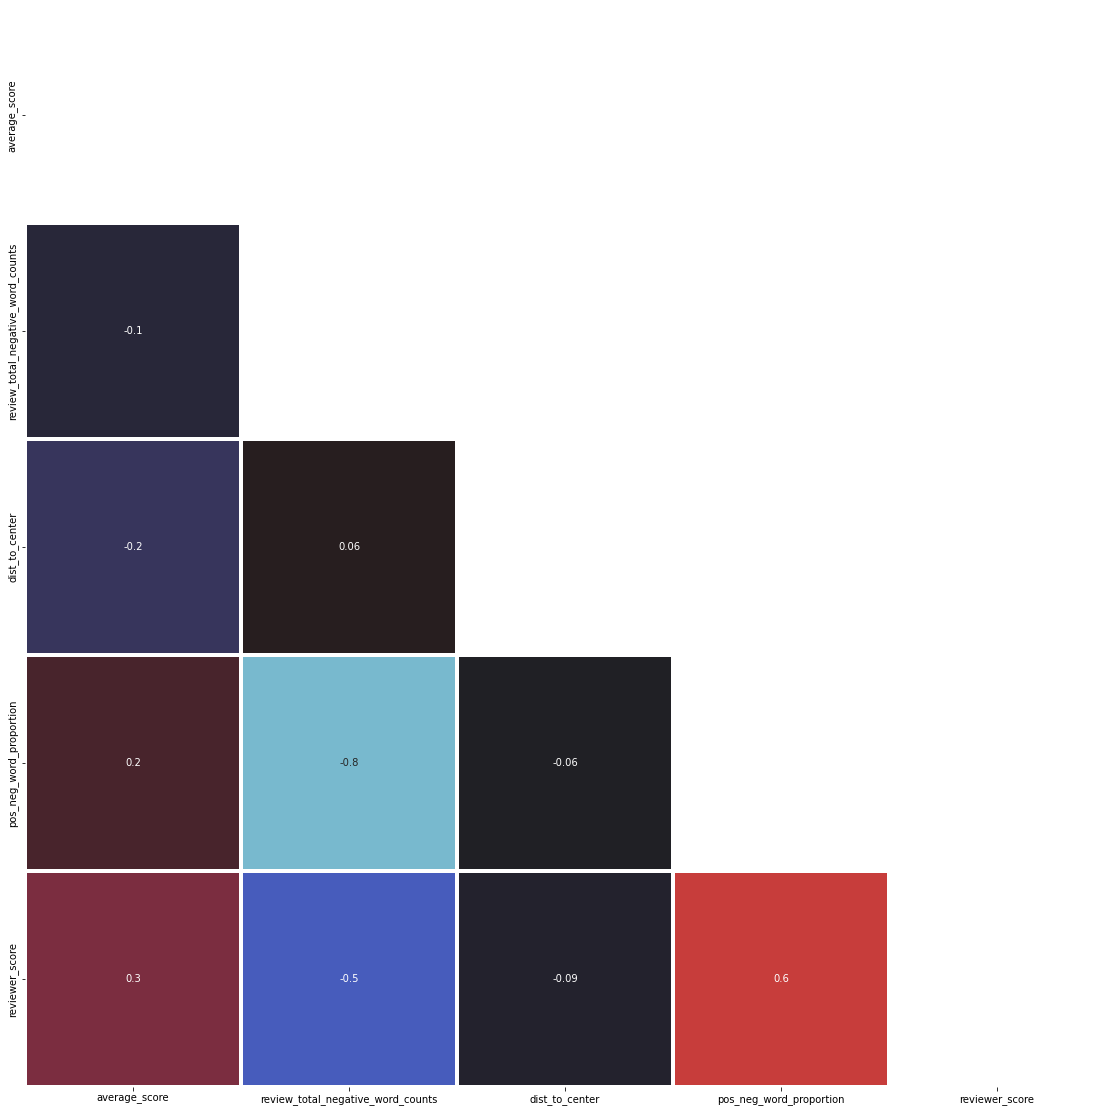

In [307]:
# Оценим тепловую карту корреляционной матрицы для новых признаков
matrix = np.triu(
    hotels_train[[
        'average_score', 'review_total_negative_word_counts', 
        'dist_to_center', 'pos_neg_word_proportion', 'reviewer_score'
    ]].corr(method='spearman')
)
fig = plt.figure(figsize=(15,15))
axes = fig.add_axes([0,0,1,1])
sns.heatmap(
    hotels_train[[
        'average_score', 'review_total_negative_word_counts', 
        'dist_to_center', 'pos_neg_word_proportion', 'reviewer_score'
    ]].corr(method='spearman'),
    annot=True,
    fmt='.1g',
    vmin = -1,
    vmax = 1,
    center = 0,
    linewidths=4,
    linecolor='white',
    cbar=False,
    mask=matrix
)

In [390]:
# Объединяем датасеты
hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)
# удаляем незначимые признаки
hotels = hotels.drop([
    'additional_number_of_scoring', 'total_number_of_reviews', 'num_tags',
    'total_number_of_reviews_reviewer_has_given', 'days_since_review'
], axis=1)

Оцениваем влияние года, месяца и дня отзыва на предсказываемый признак.

In [416]:
date = hotels_train[['review_year', 'review_month', 'review_day', 'review_day_of_week', 'reviewer_score']]
date.head()

review_year  review_month  review_day  review_day_of_week  reviewer_score
0         2016             2          19                   4            10.0
1         2017             1          12                   3             6.3
2         2016            10          18                   1             7.5
3         2015             9          22                   1            10.0
4         2016             3           5                   5             9.6

In [417]:
# Проведем грязный корреляционный анализ
date.corr(method='spearman')

review_year  review_month  review_day  review_day_of_week  \
review_year            1.000000     -0.584060   -0.025906           -0.051998   
review_month          -0.584060      1.000000   -0.009248            0.015758   
review_day            -0.025906     -0.009248    1.000000            0.008868   
review_day_of_week    -0.051998      0.015758    0.008868            1.000000   
reviewer_score         0.017356     -0.032862    0.002484           -0.006970   

                    reviewer_score  
review_year               0.017356  
review_month             -0.032862  
review_day                0.002484  
review_day_of_week       -0.006970  
reviewer_score            1.000000

Никаких значимых влияний не выявлено. Попробуем уменьшить круг поиска.

In [418]:
# Определим время года посещения отеля
date['review_winter'] = date['review_month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
date['review_spring'] = date['review_month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
date['review_summer'] = date['review_month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
date['review_autumn'] = date['review_month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1939921833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date['review_winter'] = date['review_month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1939921833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date['review_spring'] = date['review_month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_46592/1939921833.p

In [419]:
# Определим пиковое время года посещений по годам
date.groupby('review_year')[['review_winter', 'review_spring', 'review_summer', 'review_autumn']].mean()*100


review_winter  review_spring  review_summer  review_autumn
review_year                                                            
2015             18.925633       0.000000      20.320108      60.754259
2016             22.692873      24.718914      28.049538      24.538676
2017             26.835015      41.493868      31.671118       0.000000

Интересно, но наблюдается отсутствие посещения европейских стран весной 2015 и осенью 2017.

- В 2015 году пиком посещения была осень;
- В 2016 году во все сезоны был одинаковый поток;
- В 2017 году пиком была осень;

In [414]:
# Определим пиковые месяца посещений по годам
pd.DataFrame(date.groupby('review_year')['review_month'].value_counts(normalize=True)*100)

review_month
review_year review_month              
2015        9                20.862091
            10               20.740709
            8                20.320108
            11               19.151459
            12               18.925633
2016        8                10.317008
            7                 9.850003
            10                9.207304
            5                 8.694862
            9                 8.561576
            12                8.223314
            4                 8.150613
            6                 7.882527
            3                 7.873439
            1                 7.355948
            2                 7.113611
            11                6.769795
2017        7                14.972698
            5                14.834912
            1                14.394339
            6                14.113665
            4                13.657781
            3                13.001174
            2                12.440676
            8                 2.584755

- В 2015 посещения распределены равномерно с августа месяца;
- В 2016 пик был в августе, в остальные месяца был равноценен;
- В 2017 c начался спад посещений и до декабря.

Это наталкивает на мысль, что у нас есть лишь срез за определенный периоды, а не за все три года !!!

In [440]:
# Оценим в какой сезон была дана макисмальная средняя оценка
date.groupby('review_year')['reviewer_score'].count()

review_year
2015     70851
2016    198071
2017    117574
Name: reviewer_score, dtype: int64

<Axes:xlabel='reviewer_score'>

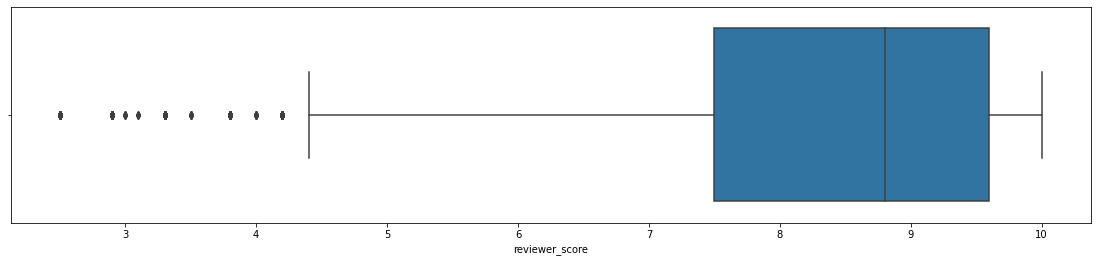

In [430]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = date[date['review_year'] == 2015],
    x='reviewer_score'
)

<Axes:xlabel='reviewer_score'>

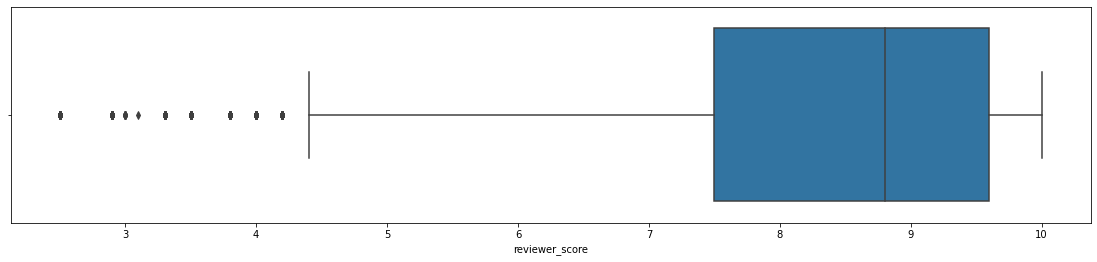

In [431]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = date[date['review_year'] == 2016],
    x='reviewer_score'
)

<Axes:xlabel='reviewer_score'>

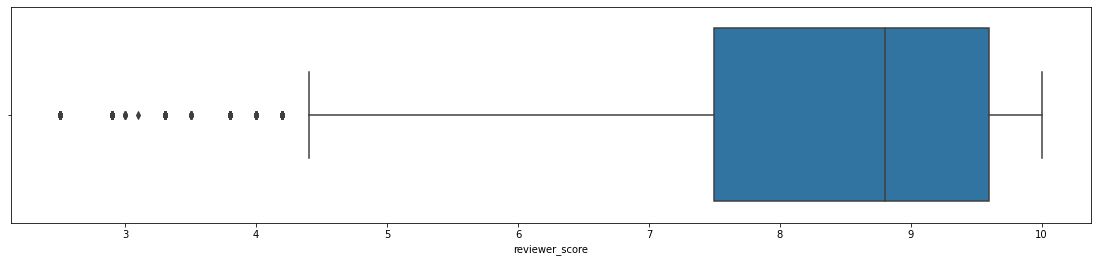

In [435]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = date[date['review_year'] == 2017],
    x='reviewer_score'
)

Ящики с усами в каждом годе посещений одинаковы.

<Axes:xlabel='review_day_of_week', ylabel='Count'>

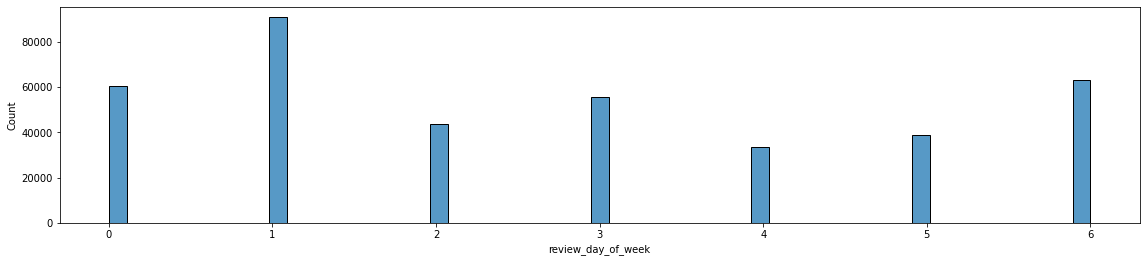

In [442]:
# Оценим в какой из дней недели чаще оставлют отзывы
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.histplot(
    data = date,
    x='review_day_of_week'
)

Во вторник больше всего отзывов оставляется. Посмотрим среднюю оценку по дням.

<Axes:xlabel='review_day_of_week', ylabel='reviewer_score'>

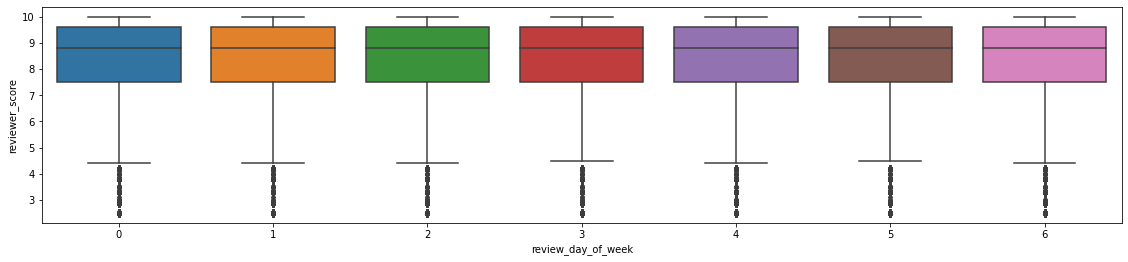

In [446]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = date,
    x='review_day_of_week',
    y='reviewer_score'
)

День недели не влияет на оценку.

Признаки даты не влияют на оценку, следовательно удалим их из датасета.

In [449]:
hotels = hotels.drop(['review_year', 'review_month', 'review_day', 'review_day_of_week'], axis=1)
hotels.head(2)

average_score  review_total_negative_word_counts  dist_to_center  \
0            8.4                                  3        1.242776   
1            8.3                                  3        1.402860   

   pos_neg_word_proportion  hotel_United Kingdom  hotel_France  \
0                     0.57                     1             0   
1                     0.40                     1             0   

   hotel_Netherlands  hotel_Italy  hotel_Austria  hotel_Spain  \
0                  0            0              0            0   
1                  0            0              0            0   

   reviewer_nationality United Kingdom   reviewer_nationality other  \
0                                     1                           0   
1                                     1                           0   

   reviewer_nationality France   reviewer_nationality Switzerland   \
0                             0                                  0   
1                             0                                  0   

   reviewer_nationality United Arab Emirates   \
0                                           0   
1                                           0   

   reviewer_nationality United States of America   \
0                                               0   
1                                               0   

   reviewer_nationality Netherlands   reviewer_nationality Italy   \
0                                  0                            0   
1                                  0                            0   

   reviewer_nationality Ireland   reviewer_nationality Canada   \
0                              0                             0   
1                              0                             0   

   reviewer_nationality Germany   reviewer_nationality Australia   \
0                              0                                0   
1                              0                                0   

   reviewer_nationality Israel   reviewer_nationality Turkey   \
0                             0                             0   
1                             0                             0   

   reviewer_nationality Belgium   reviewer_nationality Saudi Arabia   \
0                              0                                   0   
1                              0                                   0   

   tag_leisure trip  tag_couple  tag_stayed 2 nights  \
0                 1           1                    1   
1                 0           1                    0   

   tag_submitted from a mobile device  tag_business trip  \
0                                   1                  0   
1                                   0                  1   

   tag_standard double room  tag_stayed 1 night  tag_solo traveler  \
0                         0                   0                  0   
1                         1                   1                  0   

   tag_stayed 3 nights  tag_standard double or twin room  tag_stayed 6 nights  \
0                    0                                 0                    0   
1                    0                                 0                    0   

   tag_superior twin room  tag_double room non smoking  \
0                       0                            0   
1                       0                            0   

   tag_superior double room  tag_stayed 4 nights  tag_double room  \
0                         0                    0                0   
1                         0                    0                0   

   tag_family with young children  tag_double or twin room  tag_standard room  \
0                               0                        0                  0   
1                               0                        0                  0   

   tag_group  tag_comfort double or twin room  tag_standard  \
0          0                                0             0   
1          0                                0             0   

   tag_exec

In [450]:
# Оценим влияние страны на прогнозируемый признак
data_country = hotels[['hotel_United Kingdom', 'hotel_France', 'hotel_Netherlands', 'hotel_Italy', 'hotel_Austria', 'hotel_Spain', 'reviewer_score']]
data_country.head()

hotel_United Kingdom  hotel_France  hotel_Netherlands  hotel_Italy  \
0                     1             0                  0            0   
1                     1             0                  0            0   
2                     0             1                  0            0   
3                     0             1                  0            0   
4                     0             0                  1            0   

   hotel_Austria  hotel_Spain  reviewer_score  
0              0            0            10.0  
1              0            0             6.3  
2              0            0             7.5  
3              0            0            10.0  
4              0            0             9.6

In [451]:
data_country.corr(method='spearman')

hotel_United Kingdom  hotel_France  hotel_Netherlands  \
hotel_United Kingdom              1.000000     -0.368175          -0.359694   
hotel_France                     -0.368175      1.000000          -0.127801   
hotel_Netherlands                -0.359694     -0.127801           1.000000   
hotel_Italy                      -0.283934     -0.100883          -0.098559   
hotel_Austria                    -0.290995     -0.103392          -0.101010   
hotel_Spain                      -0.369999     -0.131463          -0.128434   
reviewer_score                   -0.039867      0.008839           0.008856   

                      hotel_Italy  hotel_Austria  hotel_Spain  reviewer_score  
hotel_United Kingdom    -0.283934      -0.290995    -0.369999       -0.039867  
hotel_France            -0.100883      -0.103392    -0.131463        0.008839  
hotel_Netherlands       -0.098559      -0.101010    -0.128434        0.008856  
hotel_Italy              1.000000      -0.079735    -0.101383       -0.009936  
hotel_Austria           -0.079735       1.000000    -0.103904        0.021406  
hotel_Spain             -0.101383      -0.103904     1.000000        0.034996  
reviewer_score          -0.009936       0.021406     0.034996        1.000000

<Axes:xlabel='hotel_United Kingdom', ylabel='reviewer_score'>

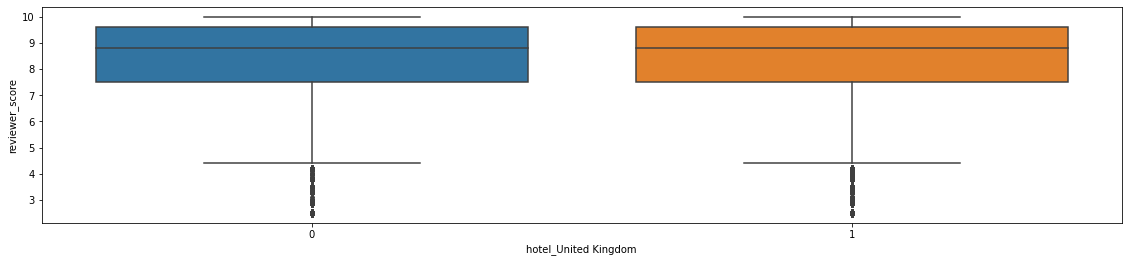

In [455]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = data_country,
    x='hotel_United Kingdom',
    y='reviewer_score'
)

<Axes:xlabel='hotel_France', ylabel='reviewer_score'>

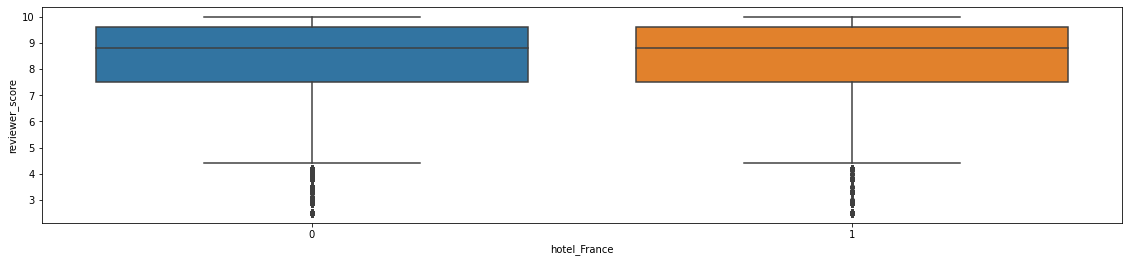

In [456]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = data_country,
    x='hotel_France',
    y='reviewer_score'
)

<Axes:xlabel='hotel_Netherlands', ylabel='reviewer_score'>

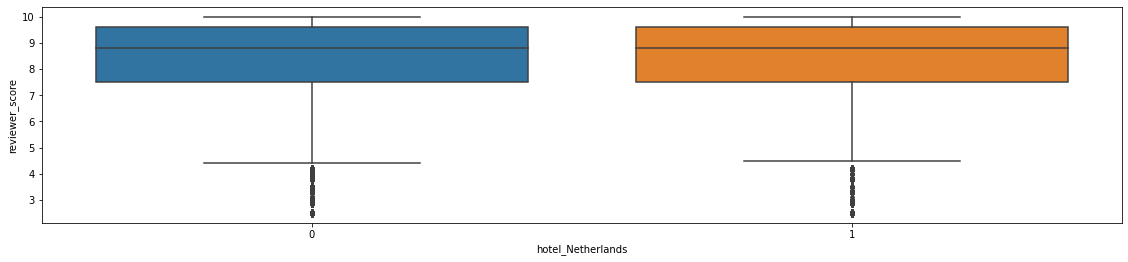

In [457]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = data_country,
    x='hotel_Netherlands',
    y='reviewer_score'
)

<Axes:xlabel='hotel_Italy', ylabel='reviewer_score'>

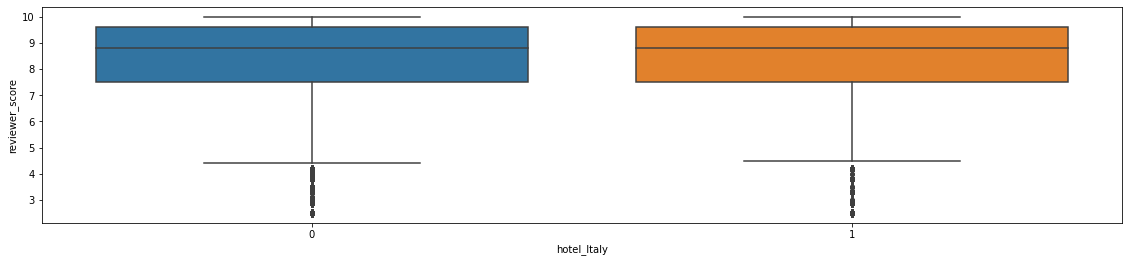

In [458]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = data_country,
    x='hotel_Italy',
    y='reviewer_score'
)

<Axes:xlabel='hotel_Austria', ylabel='reviewer_score'>

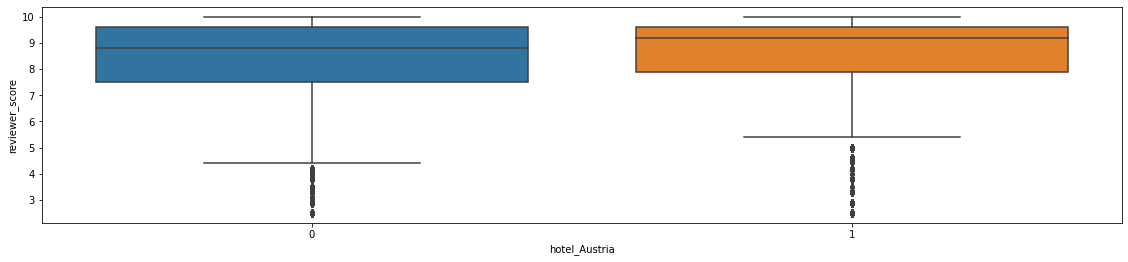

In [459]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = data_country,
    x='hotel_Austria',
    y='reviewer_score'
)

<Axes:xlabel='hotel_Spain', ylabel='reviewer_score'>

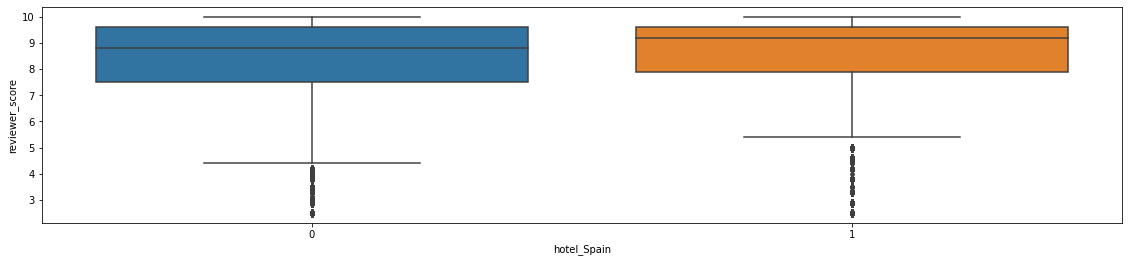

In [460]:
fig = plt.figure(figsize=(15,3))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(
    data = data_country,
    x='hotel_Spain',
    y='reviewer_score'
)

Оценим значимость признаков на прогнозируемый

In [474]:
num_cols = [
    'average_score', 'review_total_negative_word_counts', 'dist_to_center', 'pos_neg_word_proportion'
]
cat_cols = [
 'hotel_United Kingdom',
 'hotel_France',
 'hotel_Netherlands',
 'hotel_Italy',
 'hotel_Austria',
 'hotel_Spain',
 'reviewer_nationality United Kingdom ',
 'reviewer_nationality other',
 'reviewer_nationality France ',
 'reviewer_nationality Switzerland ',
 'reviewer_nationality United Arab Emirates ',
 'reviewer_nationality United States of America ',
 'reviewer_nationality Netherlands ',
 'reviewer_nationality Italy ',
 'reviewer_nationality Ireland ',
 'reviewer_nationality Canada ',
 'reviewer_nationality Germany ',
 'reviewer_nationality Australia ',
 'reviewer_nationality Israel ',
 'reviewer_nationality Turkey ',
 'reviewer_nationality Belgium ',
 'reviewer_nationality Saudi Arabia ',
 'tag_leisure trip',
 'tag_couple',
 'tag_stayed 2 nights',
 'tag_submitted from a mobile device',
 'tag_business trip',
 'tag_standard double room',
 'tag_stayed 1 night',
 'tag_solo traveler',
 'tag_stayed 3 nights',
 'tag_standard double or twin room',
 'tag_stayed 6 nights',
 'tag_superior twin room',
 'tag_double room non smoking',
 'tag_superior double room',
 'tag_stayed 4 nights',
 'tag_double room',
 'tag_family with young children',
 'tag_double or twin room',
 'tag_standard room',
 'tag_group',
 'tag_comfort double or twin room',
 'tag_standard',
 'tag_executive double room',
 'tag_2 rooms',
 'tag_family with older children',
 'tag_luxury double room',
 'tag_standard double room without window',
 'tag_basic double room',
 'tag_classic double room',
 'tag_deluxe king room',
 'tag_stayed 5 nights',
 'tag_double guest room',
 'tag_standard twin room',
 'tag_travelers with friends',
 'tag_twin room',
 'tag_small queen room',
 'tag_triple room',
 'tag_superior room',
 'tag_deluxe twin room',
 'tag_deluxe double room',
 'tag_executive king room',
 'tag_classic double or twin room',
 'tag_single room',
 'tag_queen guest room',
 'tag_standard queen room',
 'tag_king guest room',
 'tag_classic room',
 'tag_queen room',
 'tag_stayed 8 nights',
 'tag_club double room',
 'tag_large double room',
 'tag_deluxe single room',
 'tag_standard single room',
 'tag_standard triple room',
 'tag_deluxe double or twin room',
 'tag_classic single room',
 'tag_deluxe king or twin room',
 'tag_stayed 7 nights',
 'tag_superior king room',
 'tag_club twin room',
 'tag_cosy double room',
 'tag_double hilton guestroom',
 'tag_superior double or twin room',
 'tag_deluxe double',
 'tag_family room',
 'tag_superior queen room',
 'tag_twin guest room',
 'tag_double room with two double beds',
 'tag_junior suite',
 'tag_quadruple room',
 'tag_superior king or twin room',
 'tag_dorsett double room',
 'tag_classic twin room',
 'tag_small double room',
 'tag_double or twin room 1 2 adults',
 'tag_deluxe room',
 'tag_suite',
 'tag_king room',
 'tag_economy double room',
 'tag_standard double twin room',
 'tag_classic king room',
 'tag_executive twin room',
 'tag_with a pet',
 'tag_stayed 9 nights',
 'tag_comfort double room',
 'tag_superior single room',
 'tag_executive double or twin room',
 'tag_superior double room with internal view',
 'tag_executive room',
 'hotel_Ibis',
 'hotel_Hilton',
 'hotel_HolidayInn',
 'hotel_InterContinental',
 'hotel_Millennium',
 'hotel_Mercure',
 'hotel_Radisson',
 'hotel_Novotel',
 'hotel_Marriott',
 'hotel_NH',
 'hotel_TheRitzCarlton',
 'hotel_FourSeasons',
 'hotel_HyattRegency',
 'review_no_positive',
 'review_no_negative',
 'pos_markwords_staff',
 'pos_markwords_location',
 'pos_markwords_room',
 'pos_markwords_breakfast',
 'pos_markwords_clean',
 'pos_markwords_bed',
 'pos_markwords_rooms',
 'pos_markwords_station',
 'pos_markwords_service',
 'pos_markwords_bar',
 'pos_markwords_bathroom',
 'pos_markwords_view',
 'pos_markwords_food',
 'pos_markwords_metro',
 'pos_markwords_reception',
 'pos_markwords_area',
 'pos_markwords_facilities',
 'pos_markwords_restaurant',
 'neg_markwords_room',
 'neg_markwords_breakfast',
 'neg_markwords_staff',
 'neg_markwords_rooms',
 'neg_markwords_bed',
 'neg_markwords_bathroom',
 'neg_markwords_shower',
 'neg_markwords_service',
 'neg_markwords_bar',
 'neg_markwords_reception',
 'neg_markwords_price',
 'neg_markwords_floor',
 'neg_markwords_water'
]

In [471]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_train.drop(['reviewer_score'], axis = 1)  
y = hotels_train['reviewer_score']

<Axes:>

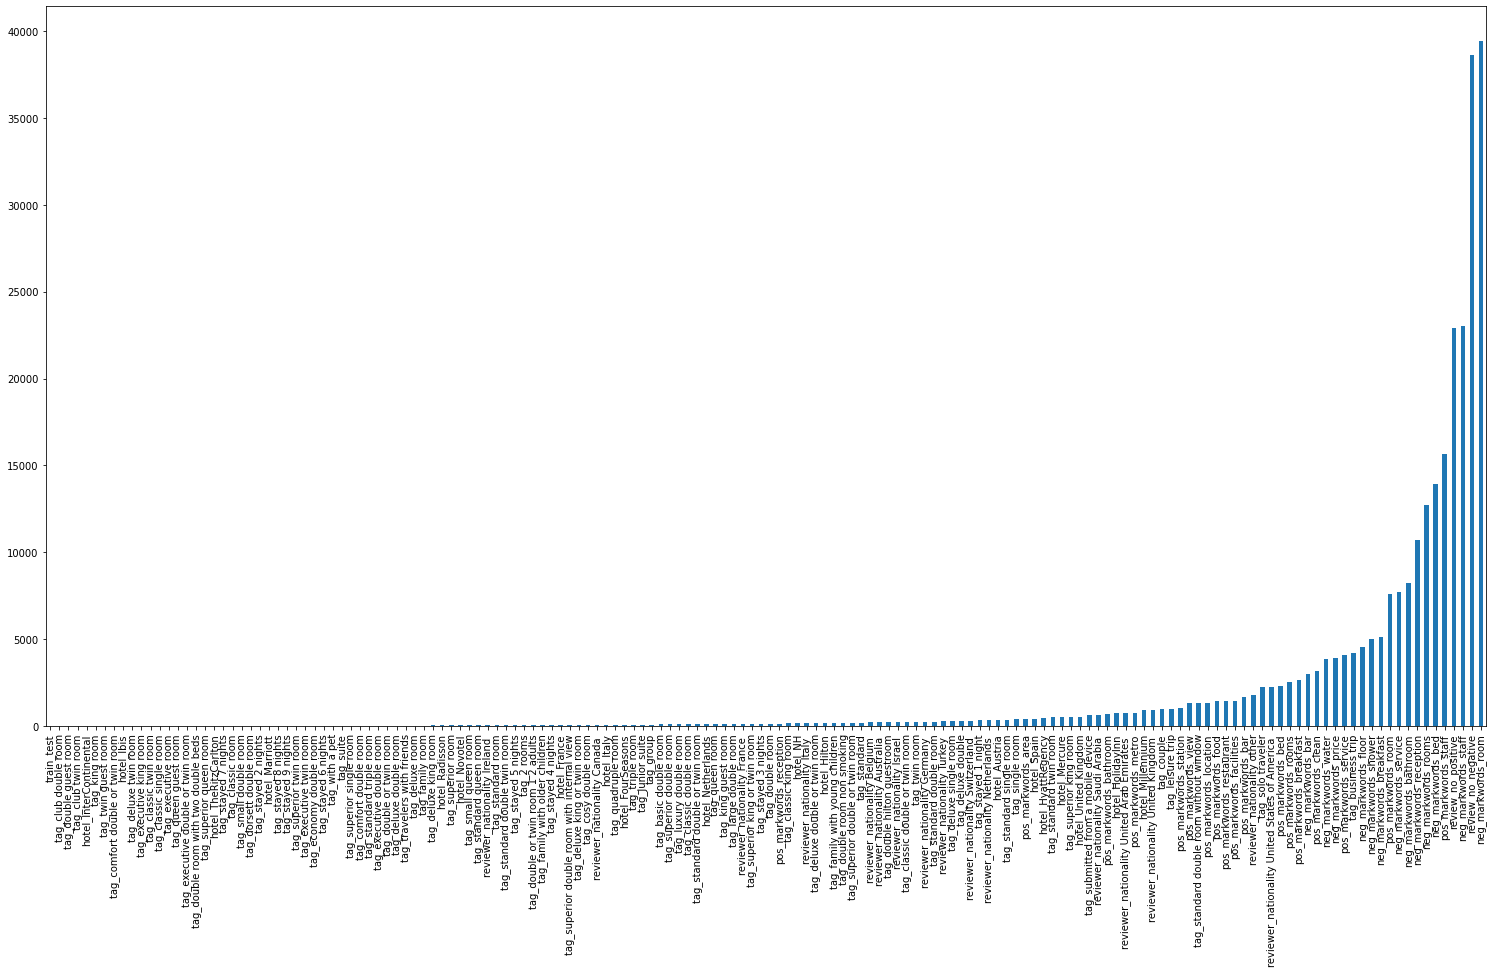

In [472]:
y=y.astype('int')
from sklearn.feature_selection import chi2

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
fig = plt.figure(figsize=(20, 10))
axes = fig.add_axes([0,0,1,1])
imp_cat.plot(kind='bar')

Больше всего на прогнозируемый признак влияют:

- 'pos_markwords_room';
- 'review_no_positive',
- 'review_no_negative',
- 'neg_markwords_staff',
- 'pos_markwords_staff',
- 'neg_markwords_bed',
- 'neg_markwords_rooms',
- 'neg_markwords_reception',
- 'neg_markwords_bathroom',
- 'neg_markwords_service',
- 'pos_markwords_room',
- 'neg_markwords_breakfast',
- 'neg_markwords_shower',
- 'neg_markwords_floor',
- 'tag_business trip',
- 'pos_markwords_service',
- 'neg_markwords_price',
- 'neg_markwords_water',
- 'neg_markwords_bar',
- 'pos_markwords_clean'


In [473]:
hotels = hotels.drop([
'hotel_United Kingdom','hotel_France','hotel_Netherlands','hotel_Italy','hotel_Austria','hotel_Spain',
'reviewer_nationality United Kingdom ','reviewer_nationality other','reviewer_nationality France ','reviewer_nationality Switzerland ',
'reviewer_nationality United Arab Emirates ','reviewer_nationality United States of America ','reviewer_nationality Netherlands ',
'reviewer_nationality Italy ','reviewer_nationality Ireland ','reviewer_nationality Canada ','reviewer_nationality Germany ','reviewer_nationality Australia ',
'reviewer_nationality Israel ','reviewer_nationality Turkey ','reviewer_nationality Belgium ','reviewer_nationality Saudi Arabia ',
'tag_leisure trip','tag_couple','tag_stayed 2 nights','tag_submitted from a mobile device','tag_standard double room','tag_stayed 1 night',
'tag_solo traveler','tag_stayed 3 nights','tag_standard double or twin room','tag_stayed 6 nights','tag_superior twin room','tag_double room non smoking',
'tag_superior double room','tag_stayed 4 nights','tag_double room','tag_family with young children','tag_double or twin room',
'tag_standard room','tag_group','tag_comfort double or twin room','tag_standard','tag_executive double room',
'tag_2 rooms','tag_family with older children','tag_luxury double room','tag_standard double room without window',
'tag_basic double room','tag_classic double room','tag_deluxe king room','tag_stayed 5 nights','tag_double guest room',
'tag_standard twin room','tag_travelers with friends','tag_twin room','tag_small queen room','tag_triple room','tag_superior room',
'tag_deluxe twin room','tag_deluxe double room','tag_executive king room','tag_classic double or twin room','tag_single room',
'tag_queen guest room','tag_standard queen room','tag_king guest room','tag_classic room','tag_queen room','tag_stayed 8 nights',
'tag_club double room','tag_large double room','tag_deluxe single room','tag_standard single room','tag_standard triple room','tag_deluxe double or twin room',
'tag_classic single room','tag_deluxe king or twin room','tag_stayed 7 nights','tag_superior king room','tag_club twin room','tag_cosy double room','tag_double hilton guestroom',
'tag_superior double or twin room','tag_deluxe double','tag_family room','tag_superior queen room','tag_twin guest room','tag_double room with two double beds',
'tag_junior suite','tag_quadruple room','tag_superior king or twin room','tag_dorsett double room','tag_classic twin room','tag_small double room',
'tag_double or twin room 1 2 adults','tag_deluxe room','tag_suite','tag_king room','tag_economy double room','tag_standard double twin room',
'tag_classic king room','tag_executive twin room','tag_with a pet','tag_stayed 9 nights','tag_comfort double room','tag_superior single room',
 'tag_executive double or twin room', 'tag_superior double room with internal view', 'tag_executive room',
 'hotel_Ibis', 'hotel_Hilton', 'hotel_HolidayInn', 'hotel_InterContinental', 'hotel_Millennium', 'hotel_Mercure',
 'hotel_Radisson', 'hotel_Novotel', 'hotel_Marriott', 'hotel_NH', 'hotel_TheRitzCarlton', 'hotel_FourSeasons',
 'hotel_HyattRegency', 'pos_markwords_location', 'pos_markwords_breakfast', 'pos_markwords_bed', 'pos_markwords_rooms', 'pos_markwords_station',
 'pos_markwords_bar', 'pos_markwords_bathroom', 'pos_markwords_view', 'pos_markwords_food', 'pos_markwords_metro',
 'pos_markwords_reception', 'pos_markwords_area', 'pos_markwords_facilities', 'pos_markwords_restaurant'
], axis=1)

<Axes:>

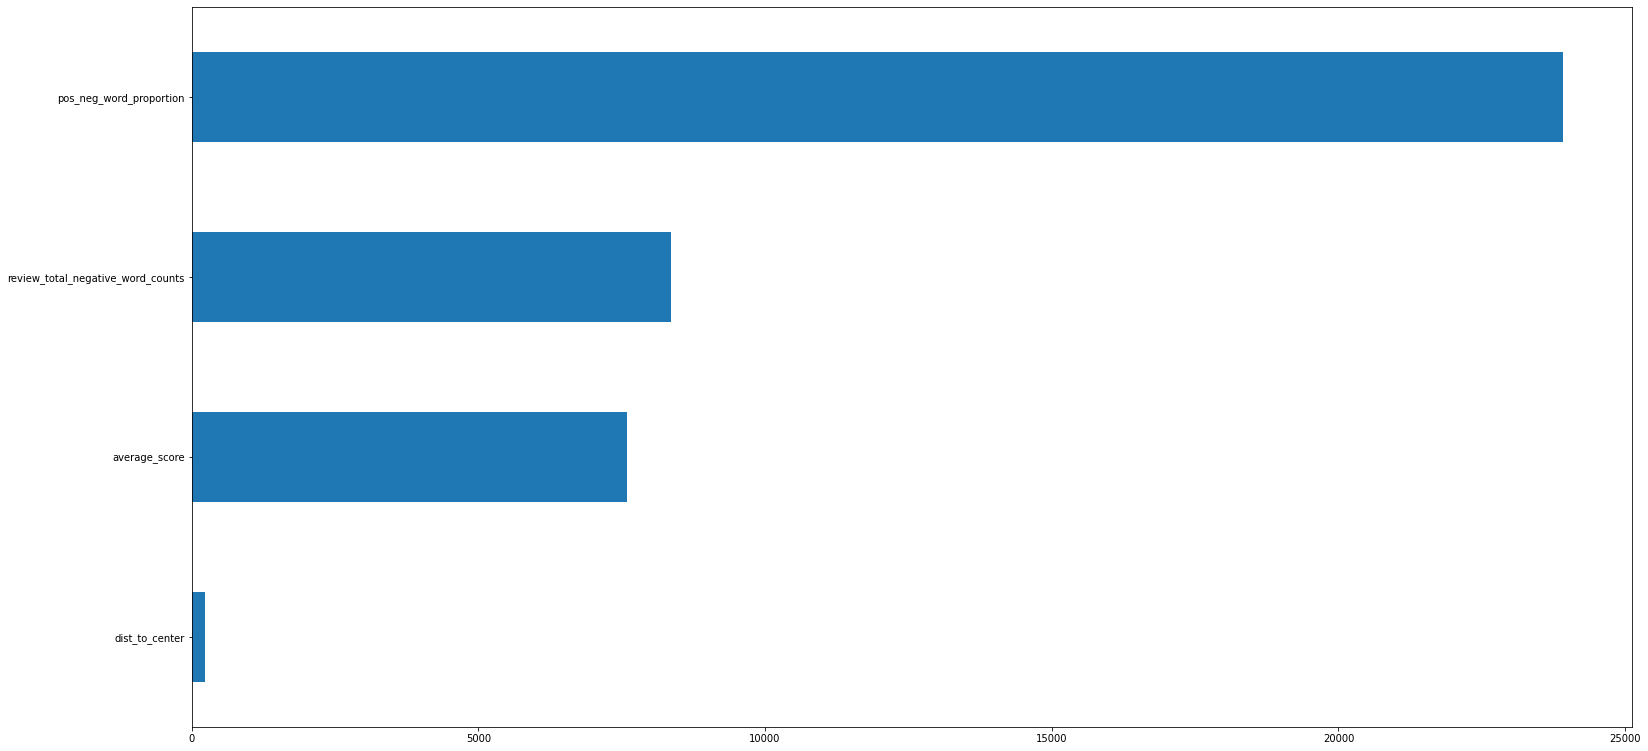

In [465]:
from sklearn.feature_selection import f_classif

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace=True)
fig = plt.figure(figsize=(20, 10))
axes = fig.add_axes([0,0,1,1])
imp_num.plot(kind = 'barh')

У признаков dist_to_center минимальное влияние.

In [475]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split

In [524]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [527]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=1000)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [528]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.15660068662501045
